In [100]:
%matplotlib notebook 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
os.chdir('/home/dana_z/ssd_2TB/6OHDA')

import numpy as np
import scipy as sci
from sklearn import svm

from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec

import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP

import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings


<b> process lfp data so that every 30s is 1 data point </b>

In [6]:
dataFile = 'Data_6OHDA_H_all.h5';

In [7]:
data = getData(dataFile,['lfp','mvmt'],period ='Pre',day = lambda x: int(x)==0)

cleaning up lfp data
I deleted session: 4539_BaselineA
cleaning up mvmt data


<IPython.core.display.Javascript object>


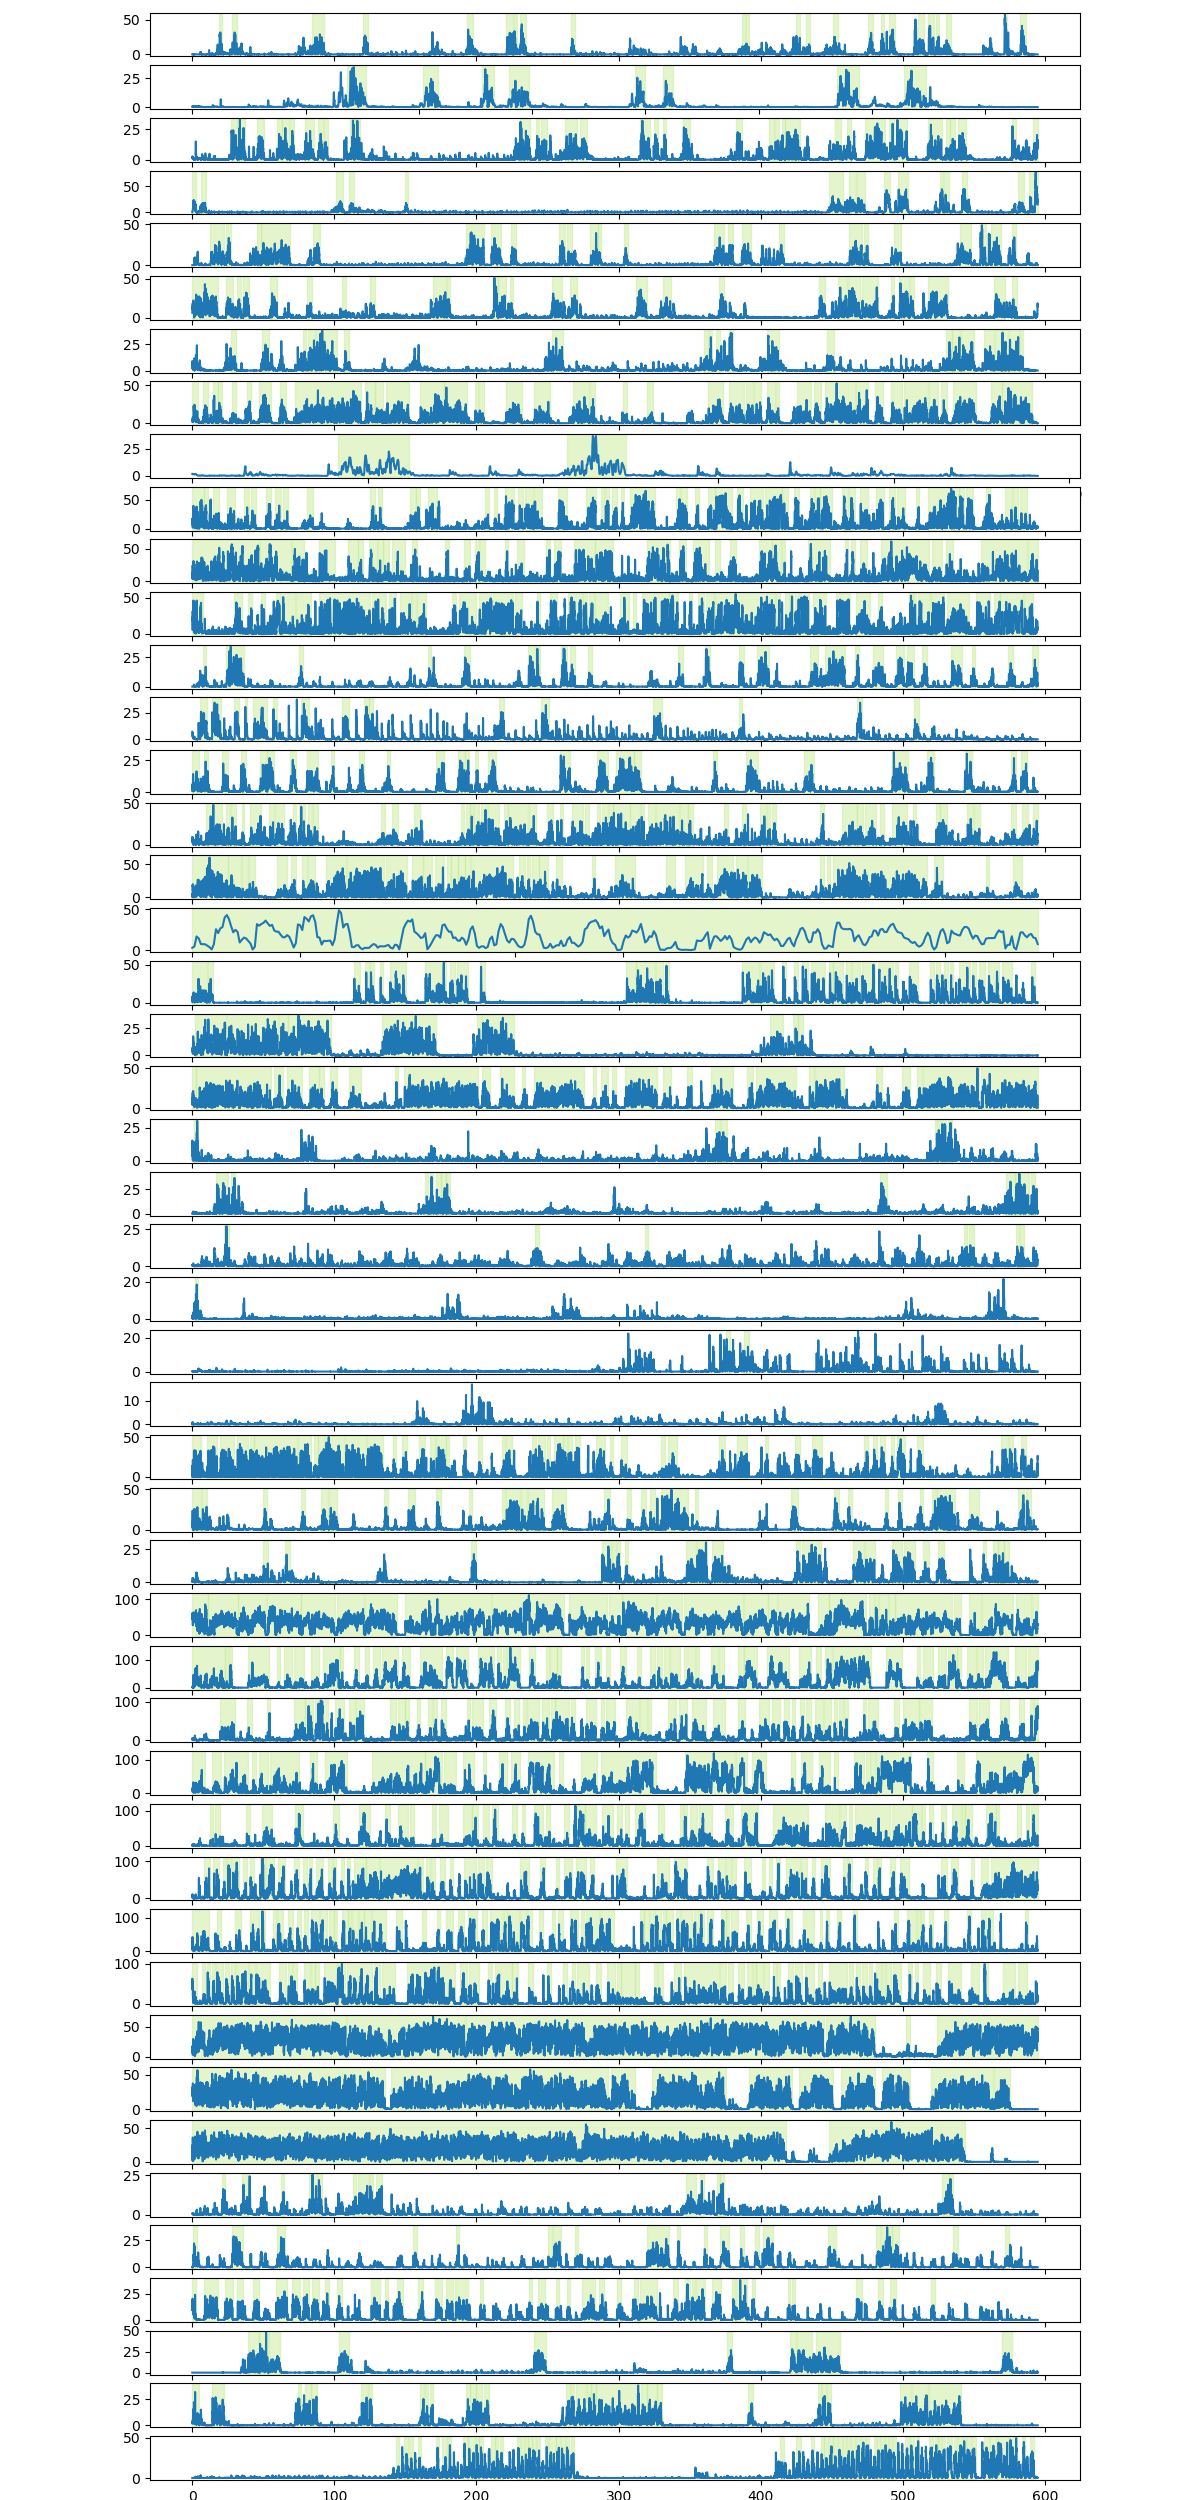

In [8]:
fig, ax = plt.subplots(len(data.keys()),1,figsize=(12, 25),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})
Colors = CP('highLowSpeed')
dt = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 2
dataPoints = int(np.ceil(Tseconds/dt))
th = 3
sessNum = 0
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed']
    dt  = 1/data[s]['mvmt']['Fs'][0]
    
    data[s]['highSpeed'] = HighSpeedPeriods(ax[sessNum],speed.T,dt,th, dataPoints, Colors['high'])
    sessNum = sessNum +1

<IPython.core.display.Javascript object>


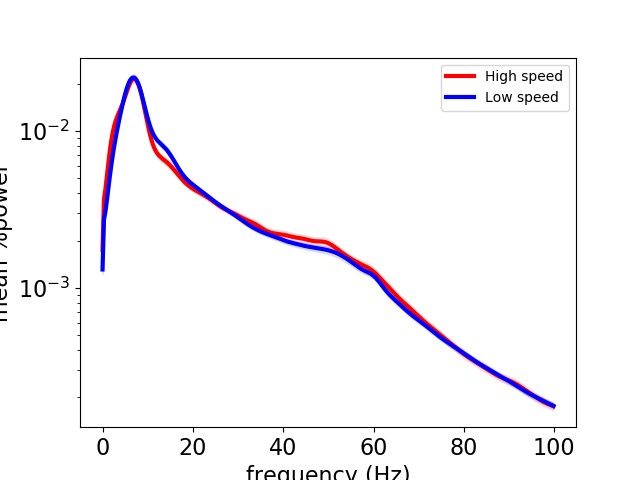

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


In [9]:
fig, ax = plt.subplots(1,1)
numS = len(data.keys())
cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/data['1208_BaselineA']['lfp']['FS'][0]

sNum = 0
phigh = []
plow = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed'].T
    lfp = data[s]['lfp']['lfp'].T[0,:]
    if len(speed)<600:
        numS = numS-1
        continue
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(data[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[data[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[data[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh.append(Power/totPower)    
    phigh.append(PowerHigh/totPowerHigh)
    plow.append(PowerLow/totPoweLow)
phigh = np.array(phigh)
plow = np.array(plow)
Mhigh = np.nanmean(phigh,axis=0)
Mlow = np.nanmean(plow,axis=0)
Stdhigh = np.nanstd(phigh, axis = 0)/np.sqrt(numS)
Stdlow = np.nanstd(plow, axis = 0)/np.sqrt(numS)
ax.semilogy(f[0:cutoff], Mhigh, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], Mlow, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], Mhigh-Stdhigh, Mhigh+Stdhigh,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], Mlow-Stdlow, Mlow+Stdlow,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

<IPython.core.display.Javascript object>


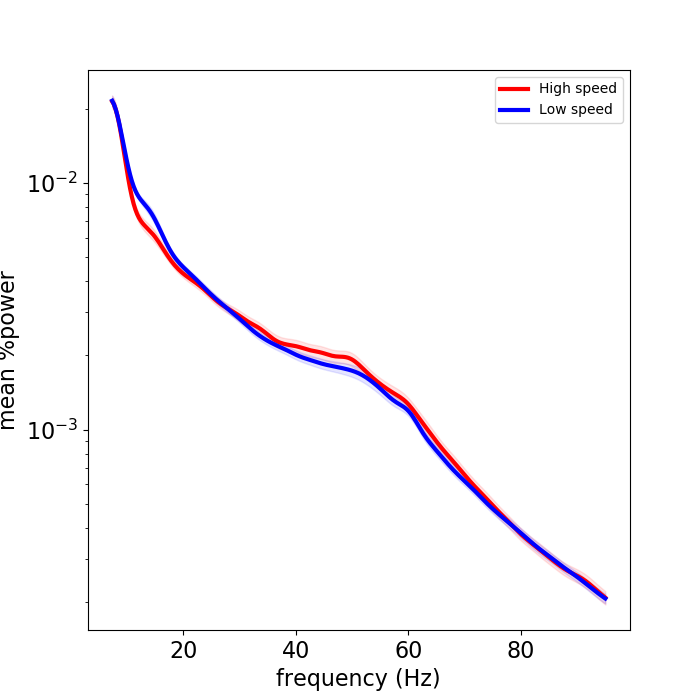

In [10]:
fig, ax = plt.subplots(1,1,figsize=(7, 7),gridspec_kw = {'top':0.9,'bottom':0.1,'wspace':0.1}
                      )
cutoff=300
ax.semilogy(f[23:cutoff], Mhigh[23:cutoff], linewidth=3,color='red', label='High speed')
ax.semilogy(f[23:cutoff], Mlow[23:cutoff], linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[23:cutoff], Mhigh[23:cutoff]-Stdhigh[23:cutoff], Mhigh[23:cutoff]+Stdhigh[23:cutoff],color='red',alpha=0.1)
ax.fill_between(f[23:cutoff], Mlow[23:cutoff]-Stdlow[23:cutoff], Mlow[23:cutoff]+Stdlow[23:cutoff],color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

In [46]:
print(t[23]-t[22])

0.05242879999999994


<IPython.core.display.Javascript object>


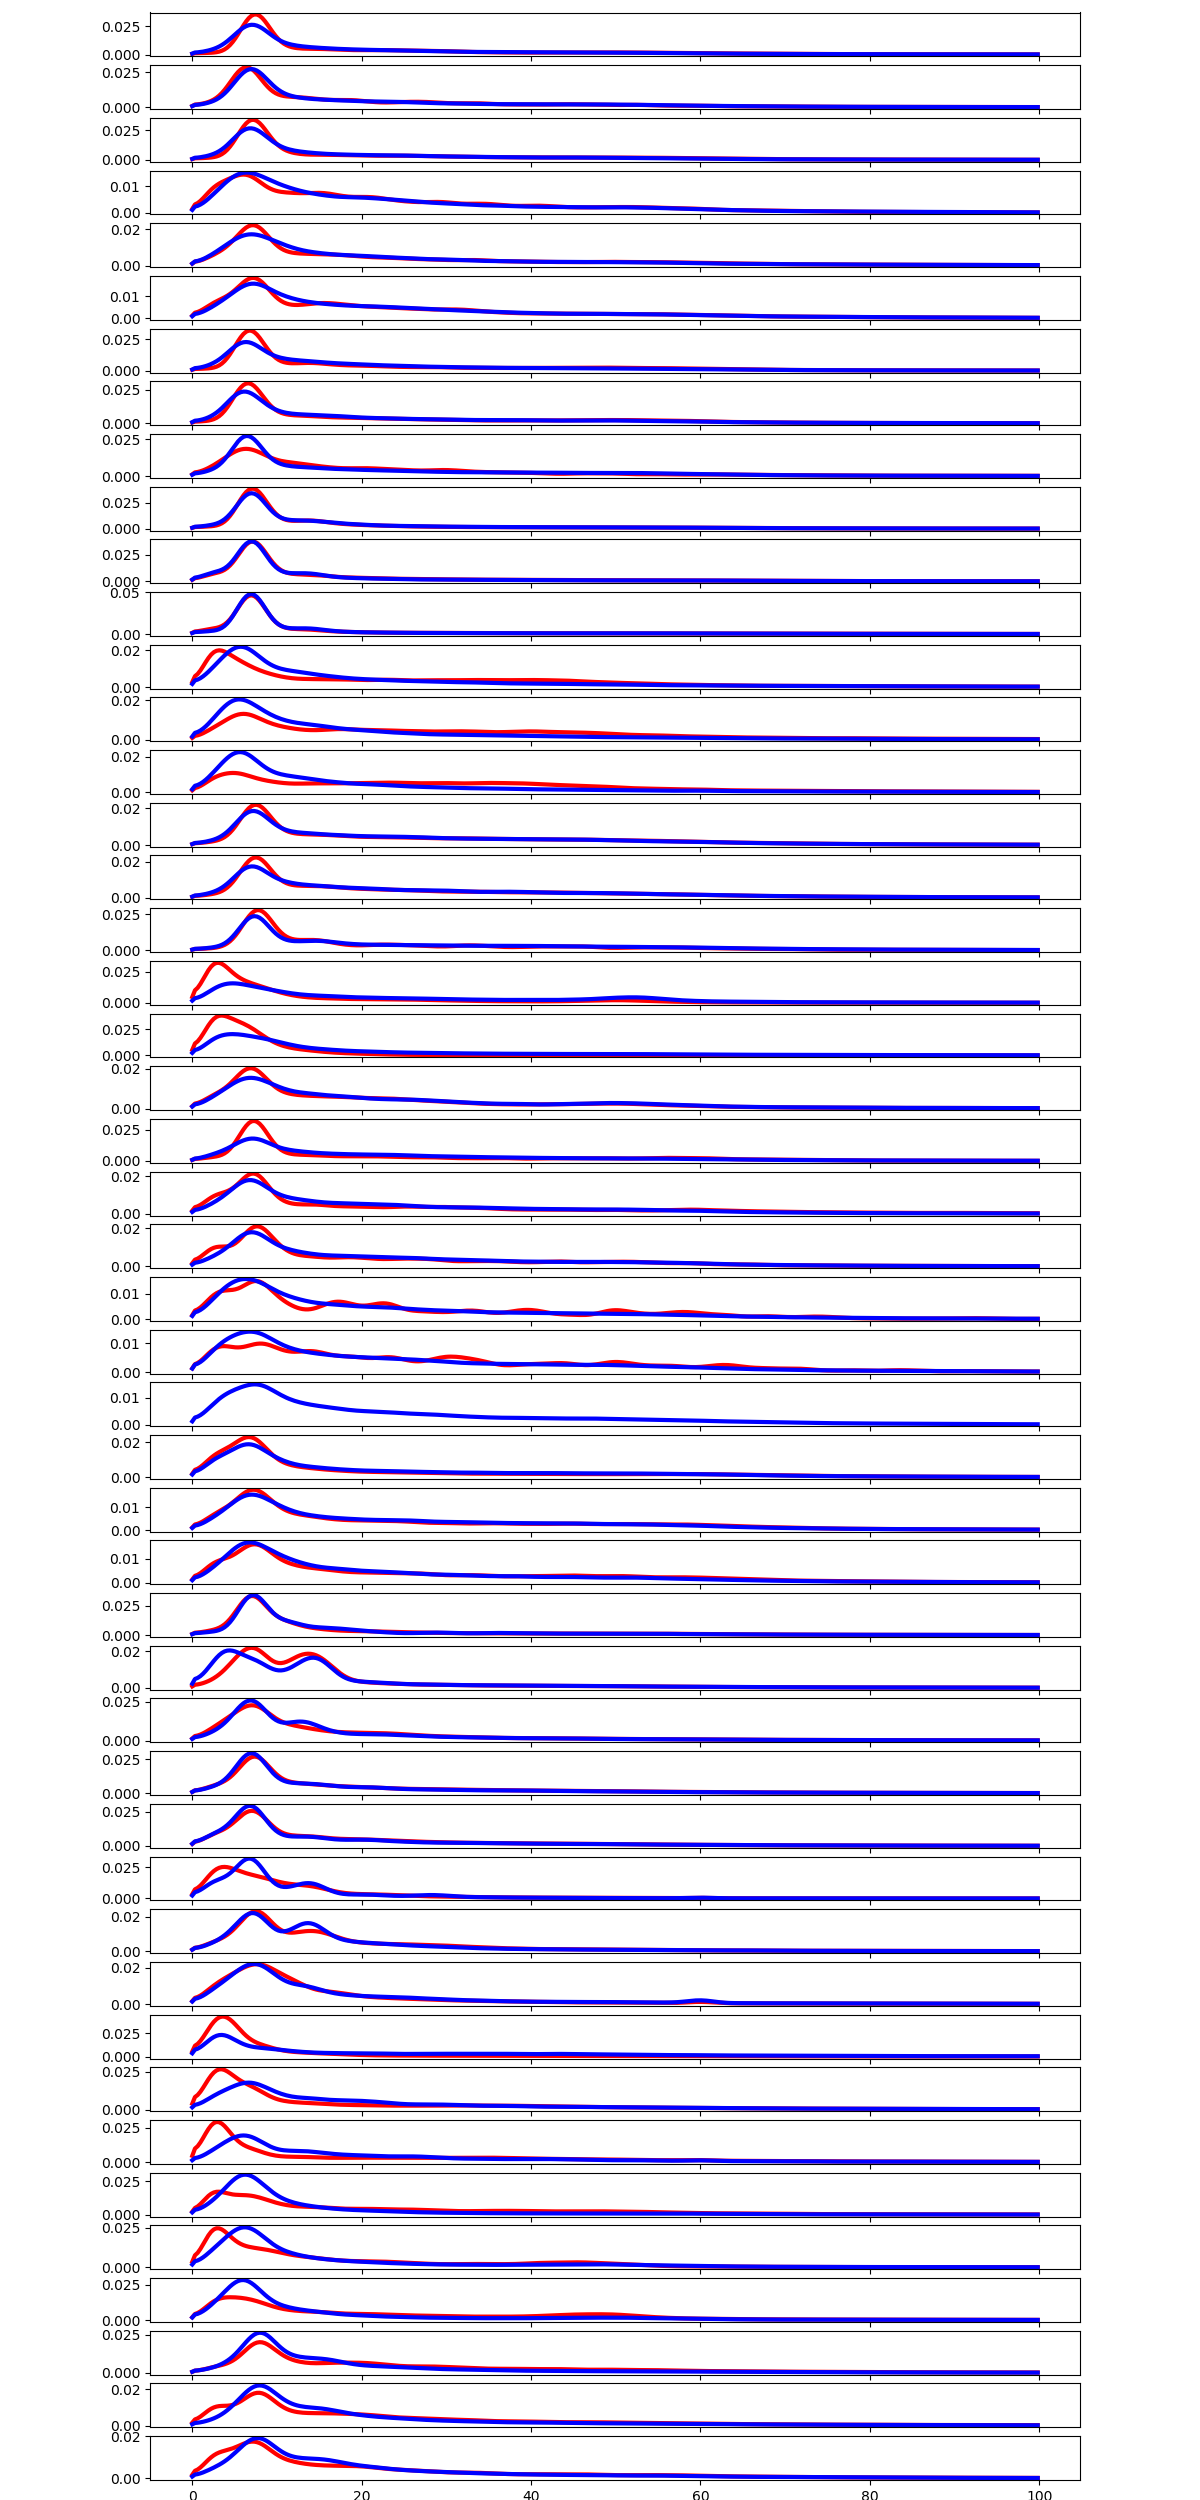

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


In [11]:
fig, ax = plt.subplots(len(data.keys()),1,figsize=(12, 25),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})


cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/data['1208_BaselineA']['lfp']['FS'][0]

sNum = 0
phigh = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed'].T
    lfp = data[s]['lfp']['lfp'].T[0,:]
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(data[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[data[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[data[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh.append(Power/totPower)    
    phigh = PowerHigh/totPowerHigh
    plow = PowerLow/totPoweLow
#    phigh = np.array(phigh)
#    M = np.nanmean(phigh,axis=0)
#    Std = np.nanstd(phigh, axis = 0)
    ax[sNum].plot(f[0:cutoff], phigh, linewidth=3,color='red')
    ax[sNum].plot(f[0:cutoff], plow, linewidth=3,color='blue')
    sNum = sNum+1 
#    ax[sNum].fill_between(f[0:cutoff], M-Std, M+Std,color='blue',alpha=0.1)

In [12]:
data = getData(dataFile,['lfp','mvmt'],period ='Pre',day = lambda x: int(x)>3)

cleaning up lfp data
I deleted session: 7584_day12
I deleted session: 7584_day30A
I deleted session: 7909_day15A
I deleted session: 7909_day30A
cleaning up mvmt data


<IPython.core.display.Javascript object>


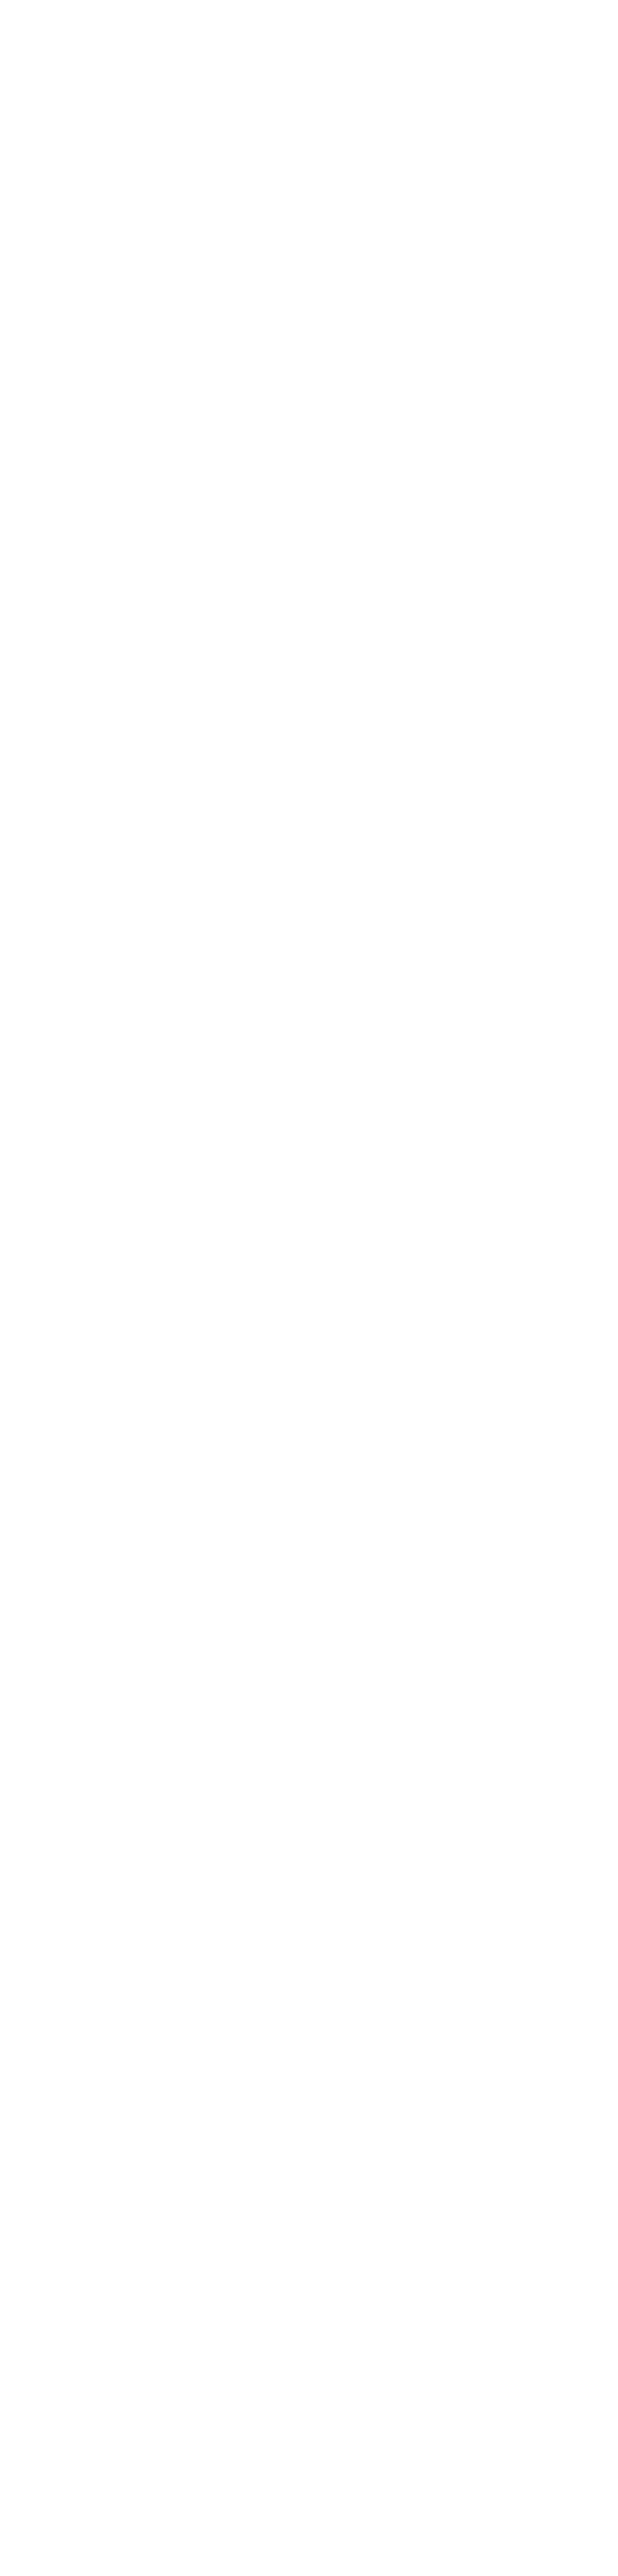

In [13]:
fig, ax = plt.subplots(len(data.keys()),1,figsize=(12, 50),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})
Colors = CP('highLowSpeed')
dt = 1/data['0761_day10']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 2
dataPoints = int(np.ceil(Tseconds/dt))
th = 3
sessNum = 0
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed']
    dt  = 1/data[s]['mvmt']['Fs'][0]
    
    data[s]['highSpeed'] = HighSpeedPeriods(ax[sessNum],speed.T,dt,th, dataPoints, Colors['high'])
    sessNum = sessNum +1

<IPython.core.display.Javascript object>


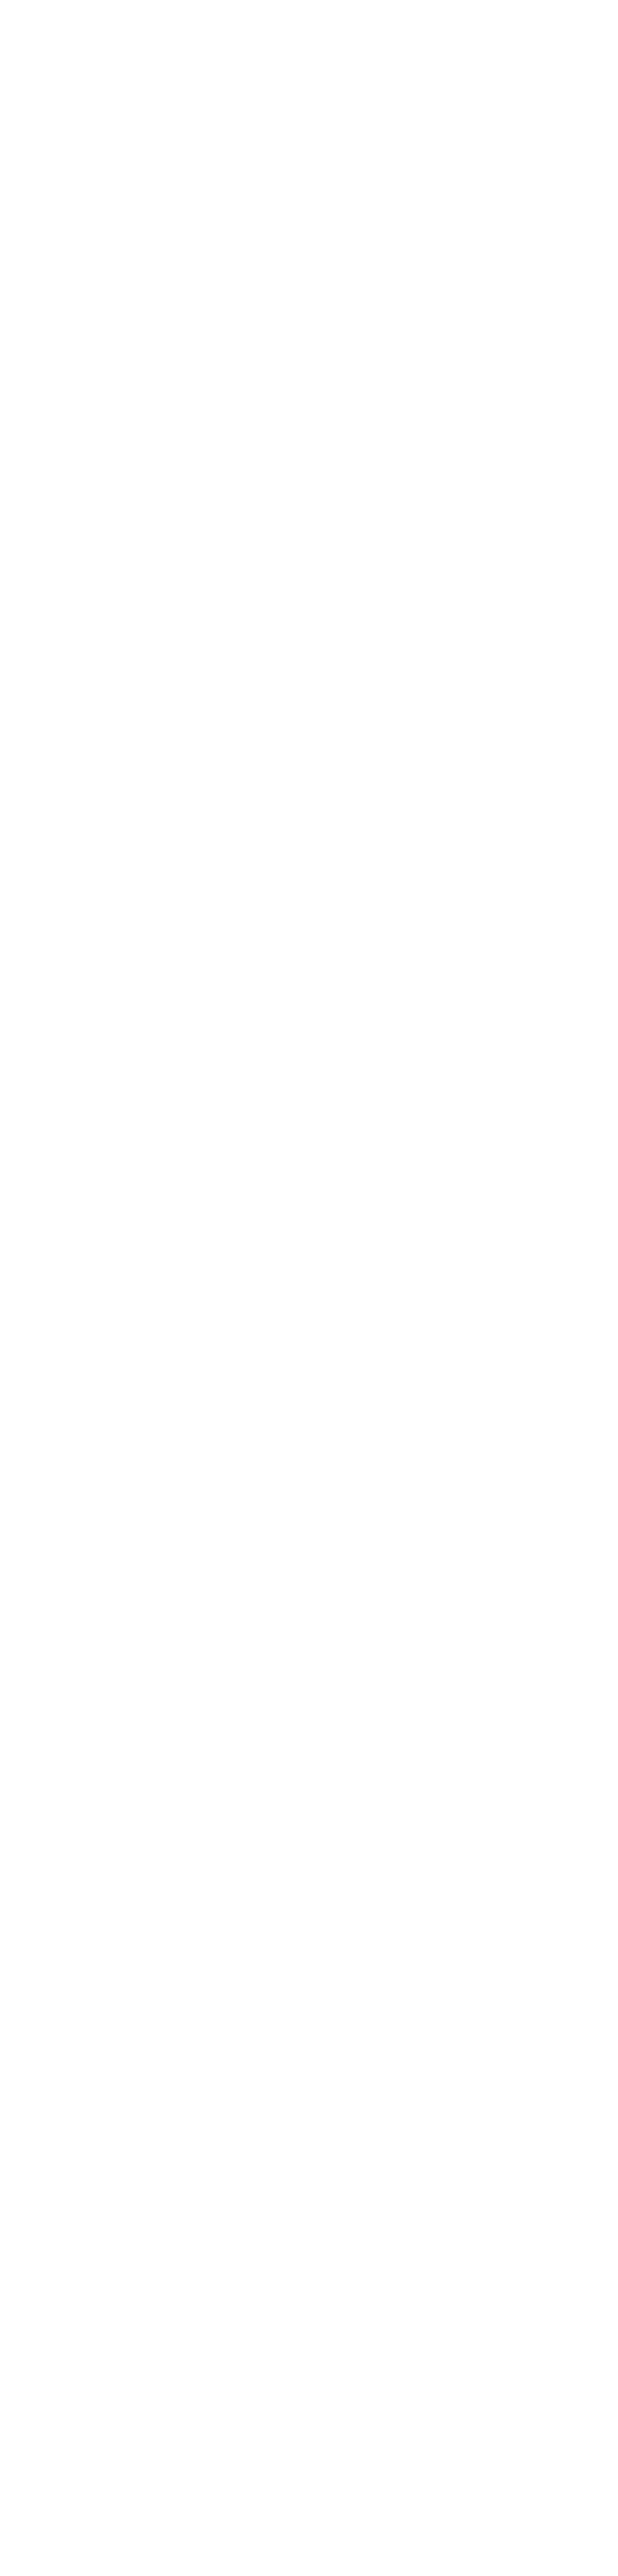

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


In [14]:
fig, ax = plt.subplots(len(data.keys()),1,figsize=(12, 50),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})


cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/data['0761_day10']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/data['0761_day10']['lfp']['FS'][0]

sNum = 0
phigh = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed'].T
    lfp = data[s]['lfp']['lfp'].T[0,:]
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(data[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[data[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[data[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh.append(Power/totPower)    
    phigh = PowerHigh/totPowerHigh
    plow = PowerLow/totPoweLow
#    phigh = np.array(phigh)
#    M = np.nanmean(phigh,axis=0)
#    Std = np.nanstd(phigh, axis = 0)
    ax[sNum].plot(f[0:cutoff], phigh, linewidth=3,color='red')
    ax[sNum].plot(f[0:cutoff], plow, linewidth=3,color='blue')
    sNum = sNum+1 
#    ax[sNum].fill_between(f[0:cutoff], M-Std, M+Std,color='blue',alpha=0.1)

<IPython.core.display.Javascript object>


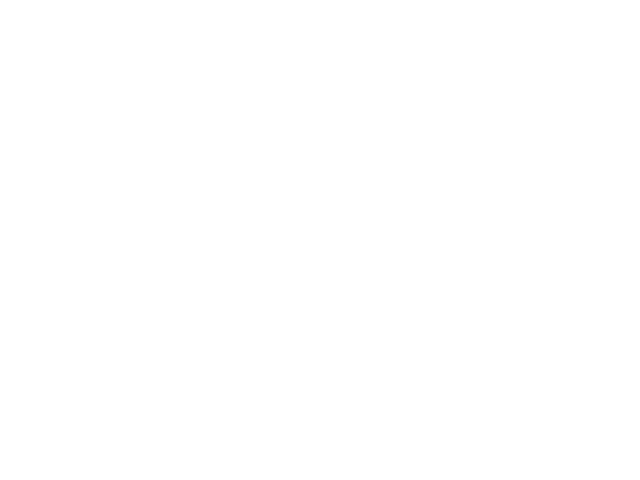

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


In [15]:
fig, ax = plt.subplots(1,1)
numS = len(data.keys())
cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/data['0761_day10']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/data['0761_day10']['lfp']['FS'][0]

sNum = 0
phigh = []
plow = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed'].T
    lfp = data[s]['lfp']['lfp'].T[0,:]
    if len(speed)<600:
        numS = numS-1
        continue
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(data[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[data[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[data[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh.append(Power/totPower)    
    phigh.append(PowerHigh/totPowerHigh)
    plow.append(PowerLow/totPoweLow)
phigh = np.array(phigh)
plow = np.array(plow)
Mhigh = np.nanmean(phigh,axis=0)
Mlow = np.nanmean(plow,axis=0)
Stdhigh = np.nanstd(phigh, axis = 0)/np.sqrt(numS)
Stdlow = np.nanstd(plow, axis = 0)/np.sqrt(numS)
ax.semilogy(f[0:cutoff], Mhigh, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], Mlow, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], Mhigh-Stdhigh, Mhigh+Stdhigh,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], Mlow-Stdlow, Mlow+Stdlow,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

<IPython.core.display.Javascript object>


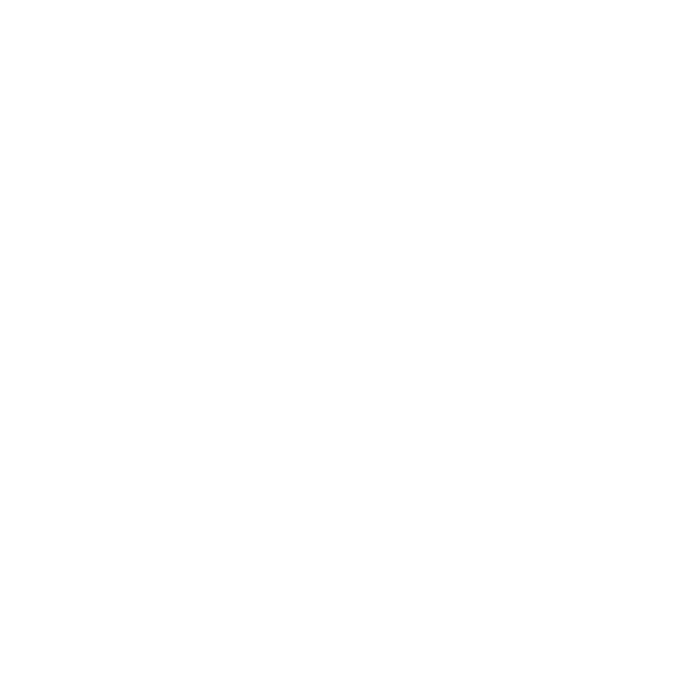

In [16]:
fig, ax = plt.subplots(1,1,figsize=(7, 7),gridspec_kw = {'top':0.9,'bottom':0.1,'wspace':0.1}
                      )
cutoff=100
ax.semilogy(f[23:cutoff], Mhigh[23:cutoff], linewidth=3,color='red', label='High speed')
ax.semilogy(f[23:cutoff], Mlow[23:cutoff], linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[23:cutoff], Mhigh[23:cutoff]-Stdhigh[23:cutoff], Mhigh[23:cutoff]+Stdhigh[23:cutoff],color='red',alpha=0.1)
ax.fill_between(f[23:cutoff], Mlow[23:cutoff]-Stdlow[23:cutoff], Mlow[23:cutoff]+Stdlow[23:cutoff],color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

In [17]:
dataPost = getData(dataFile,['lfp','mvmt'],period ='Post',drug=b'Amphetamin' ,day = lambda x: int(x)>3)
dataPre = getData(dataFile,['lfp','mvmt'],period ='Post',drug=b'Amphetamin' ,day = lambda x: int(x)==0)

cleaning up lfp data
I deleted session: 7584_day30A
I deleted session: 7909_day15A
I deleted session: 7909_day30A
cleaning up mvmt data
cleaning up lfp data
I deleted session: 4539_BaselineA
cleaning up mvmt data


<IPython.core.display.Javascript object>


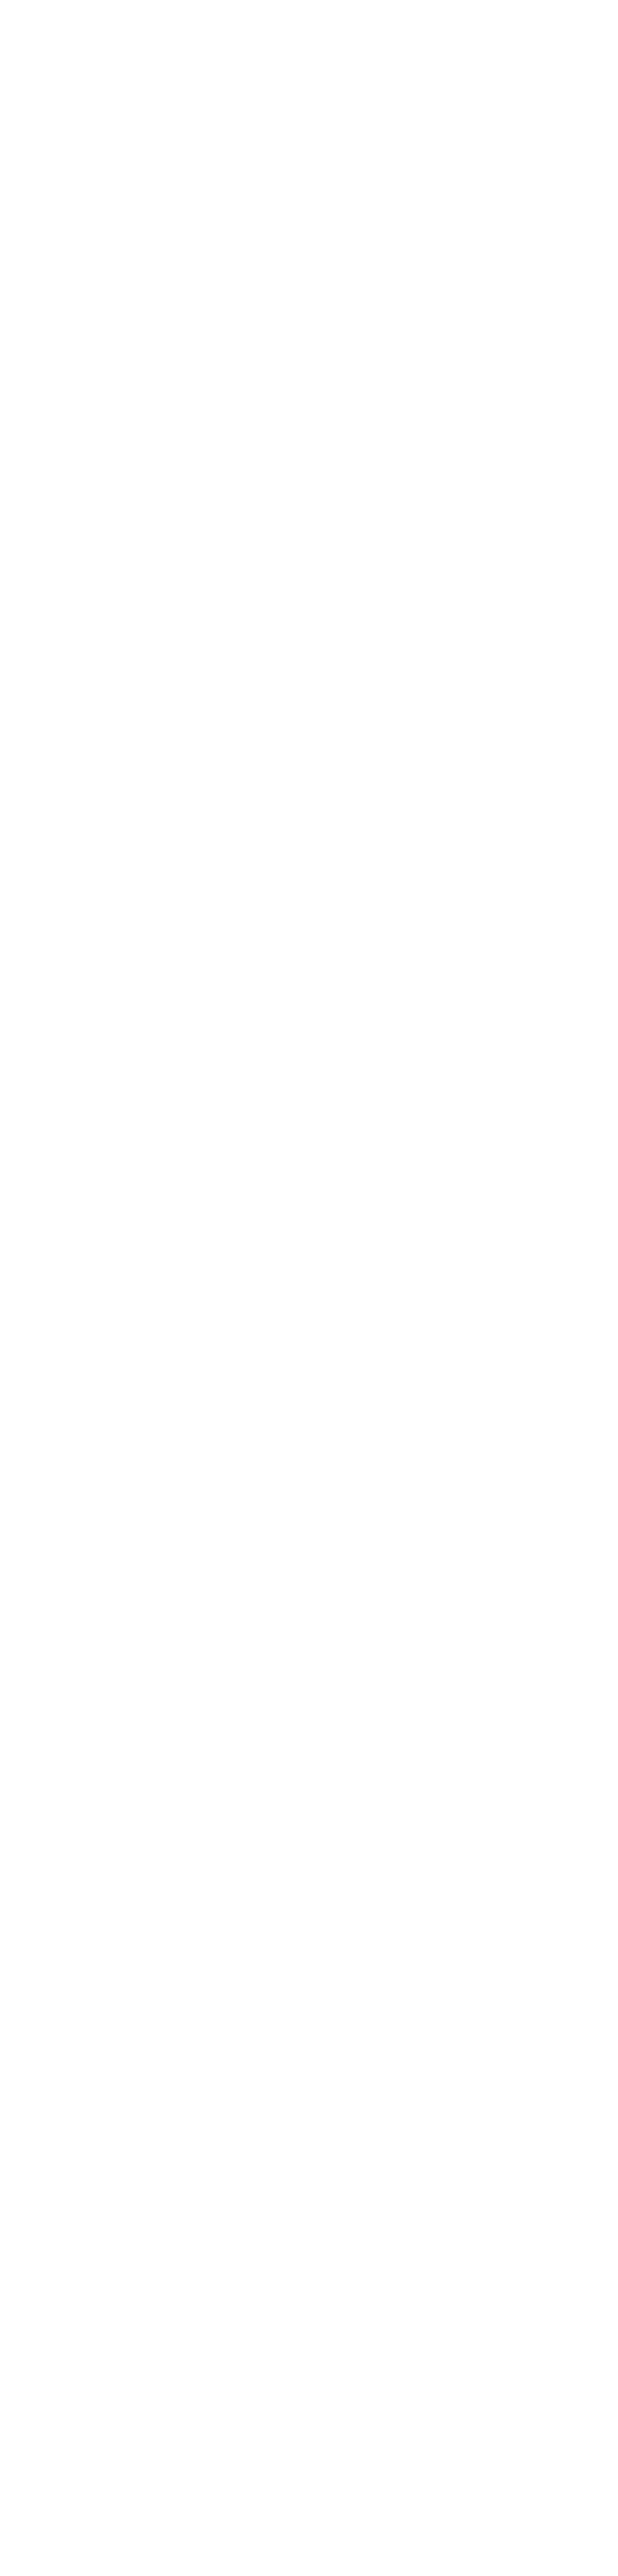

In [18]:
fig, ax = plt.subplots(len(dataPost.keys()),1,figsize=(12, 50),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})
Colors = CP('highLowSpeed')
dt = 1/20   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 2
dataPoints = int(np.ceil(Tseconds/dt))
th = 3
sessNum = 0
for s in dataPost.keys():
    #find movment onset:
    speed = dataPost[s]['mvmt']['speed']
    dt  = 1/dataPost[s]['mvmt']['Fs'][0]
    
    dataPost[s]['highSpeed'] = HighSpeedPeriods(ax[sessNum],speed.T,dt,th, dataPoints, Colors['high'])
    sessNum = sessNum +1

<IPython.core.display.Javascript object>


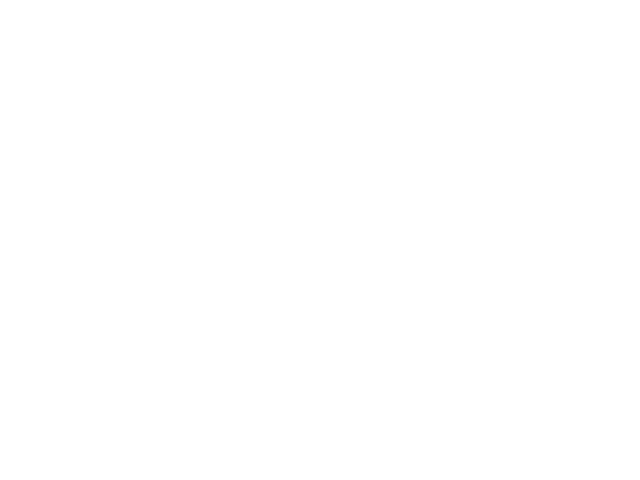

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [19]:
fig, ax = plt.subplots(1,1)
numS = len(dataPost.keys())
cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/dataPost['0761_day14A']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/dataPost['0761_day14A']['lfp']['FS'][0]

sNum = 0
phigh = []
plow = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in dataPost.keys():
    #find movment onset:
    speed = dataPost[s]['mvmt']['speed'].T
    lfp = dataPost[s]['lfp']['lfp'].T[0,:]
    if len(speed)<600:
        numS = numS-1
        continue
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(dataPost[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[dataPost[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[dataPost[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh.append(Power/totPower)    
    phigh.append(PowerHigh/totPowerHigh)
    plow.append(PowerLow/totPoweLow)
phigh = np.array(phigh)
plow = np.array(plow)
Mhigh = np.nanmean(phigh,axis=0)
Mlow = np.nanmean(plow,axis=0)
Stdhigh = np.nanstd(phigh, axis = 0)/np.sqrt(numS)
Stdlow = np.nanstd(plow, axis = 0)/np.sqrt(numS)
ax.semilogy(f[0:cutoff], Mhigh, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], Mlow, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], Mhigh-Stdhigh, Mhigh+Stdhigh,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], Mlow-Stdlow, Mlow+Stdlow,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

<IPython.core.display.Javascript object>


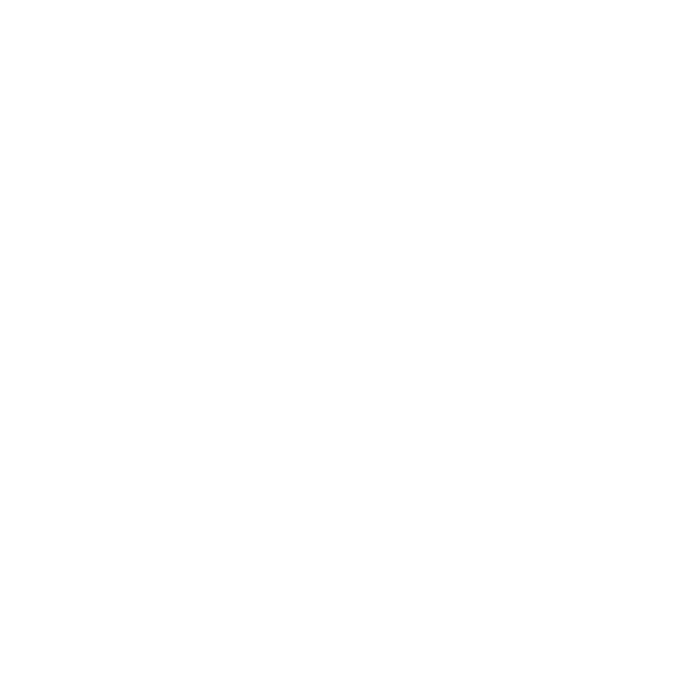

In [20]:
fig, ax = plt.subplots(1,1,figsize=(7, 7),gridspec_kw = {'top':0.9,'bottom':0.1,'wspace':0.1}
                      )
cutoff=100
ax.semilogy(f[23:cutoff], Mhigh[23:cutoff], linewidth=3,color='red', label='High speed + Amphetamine')
ax.semilogy(f[23:cutoff], Mlow[23:cutoff], linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[23:cutoff], Mhigh[23:cutoff]-Stdhigh[23:cutoff], Mhigh[23:cutoff]+Stdhigh[23:cutoff],color='red',alpha=0.1)
ax.fill_between(f[23:cutoff], Mlow[23:cutoff]-Stdlow[23:cutoff], Mlow[23:cutoff]+Stdlow[23:cutoff],color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()


<IPython.core.display.Javascript object>


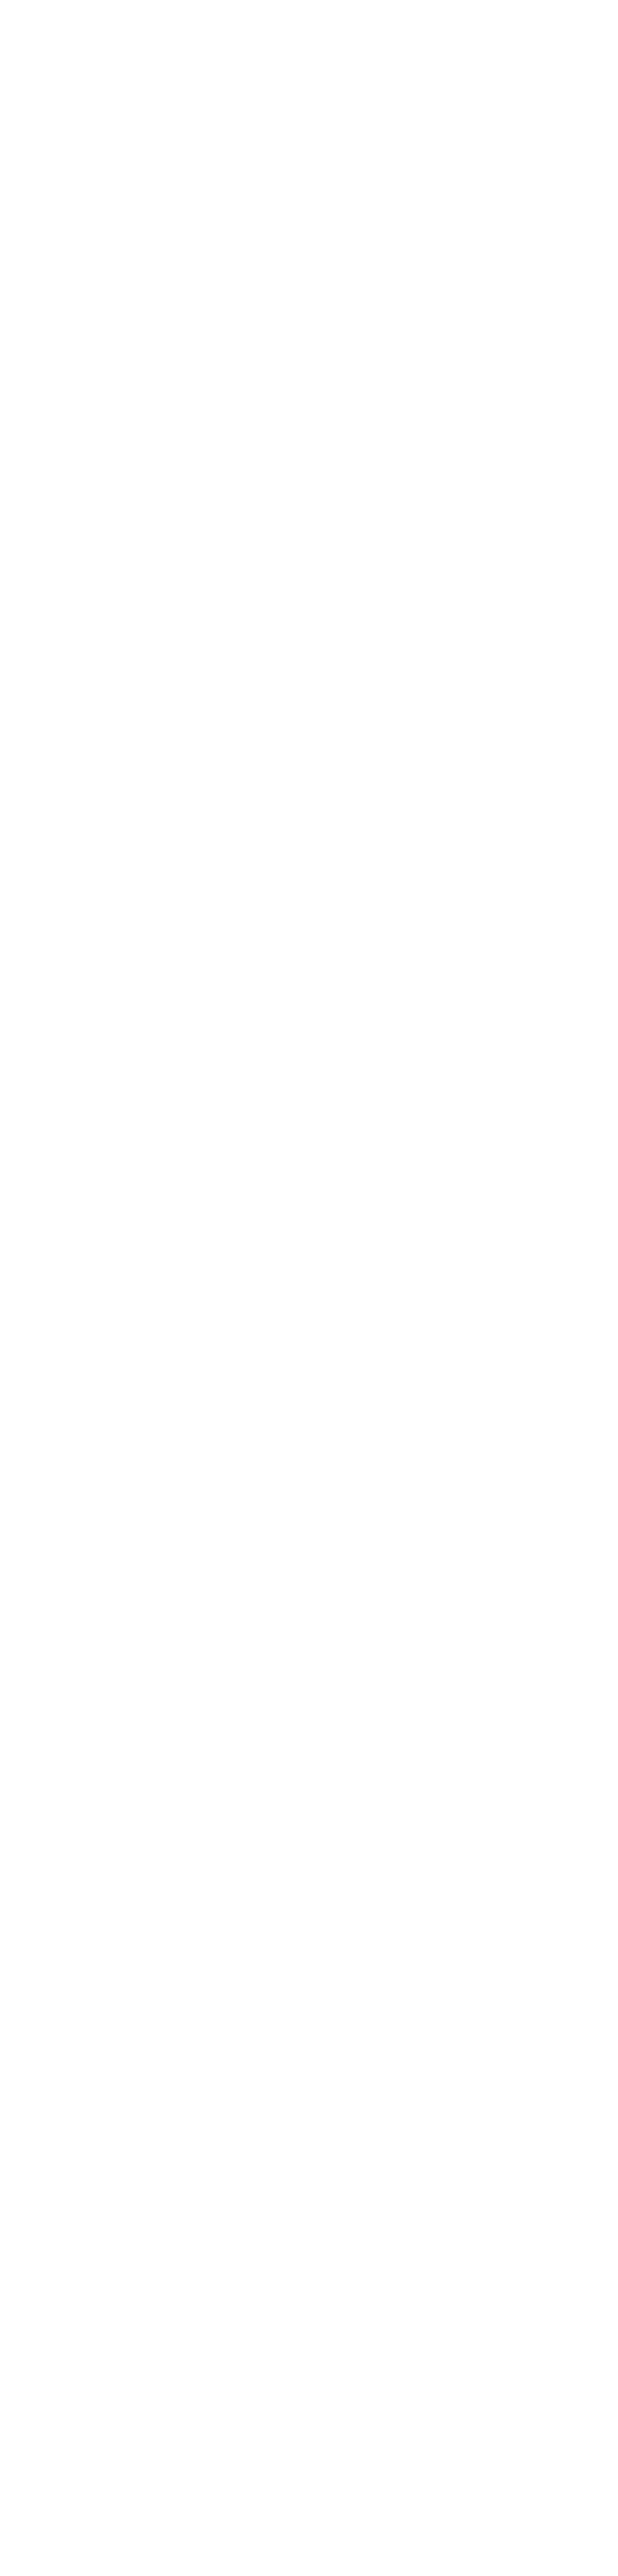

In [21]:
fig, ax = plt.subplots(len(dataPre.keys()),1,figsize=(12, 50),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})
Colors = CP('highLowSpeed')
dt = 1/20   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 2
dataPoints = int(np.ceil(Tseconds/dt))
th = 3
sessNum = 0
for s in dataPre.keys():
    #find movment onset:
    speed = dataPre[s]['mvmt']['speed']
    dt  = 1/dataPre[s]['mvmt']['Fs'][0]
    
    dataPre[s]['highSpeed'] = HighSpeedPeriods(ax[sessNum],speed.T,dt,th, dataPoints, Colors['high'])
    sessNum = sessNum +1

<IPython.core.display.Javascript object>


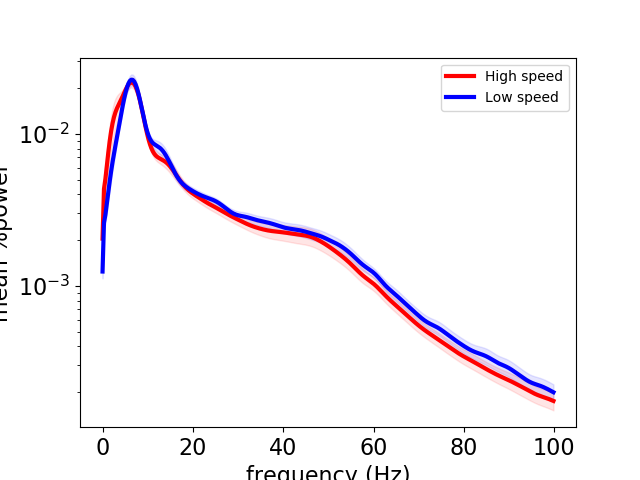

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
/home/dana_z/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 140 is greater than input length  = 0, using nperseg = 0
  .format(nperseg, input_length))


4539_Baseline2A  something went wrong


In [27]:
fig, ax = plt.subplots(1,1)
numS = len(dataPre.keys())
cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/dataPre['0761_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/dataPre['0761_BaselineA']['lfp']['FS'][0]

sNum = 0
phighpre = []
plowPre = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in dataPre.keys():
    #find movment onset:
    speed = dataPre[s]['mvmt']['speed'].T
    lfp = dataPre[s]['lfp']['lfp'].T[0,:]
    if len(speed)<600:
        numS = numS-1
        continue
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    try:
        sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    except:
        print(s, ' something went wrong')
        continue
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(dataPre[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[dataPre[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[dataPre[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phighpre.append(Power/totPower)    
    phighpre.append(PowerHigh/totPowerHigh)
    plowPre.append(PowerLow/totPoweLow)
phighpre = np.array(phighpre)
plowPre = np.array(plowPre)
MhighPre = np.nanmean(phighpre,axis=0)
MlowPre = np.nanmean(plowPre,axis=0)
StdPrehigh = np.nanstd(phighpre, axis = 0)/np.sqrt(numS)
StdPrelow = np.nanstd(plowPre, axis = 0)/np.sqrt(numS)
ax.semilogy(f[0:cutoff], MhighPre, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], MlowPre, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], MhighPre-StdPrehigh, MhighPre+StdPrehigh,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], MlowPre-StdPrelow, MlowPre+StdPrelow,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

<IPython.core.display.Javascript object>


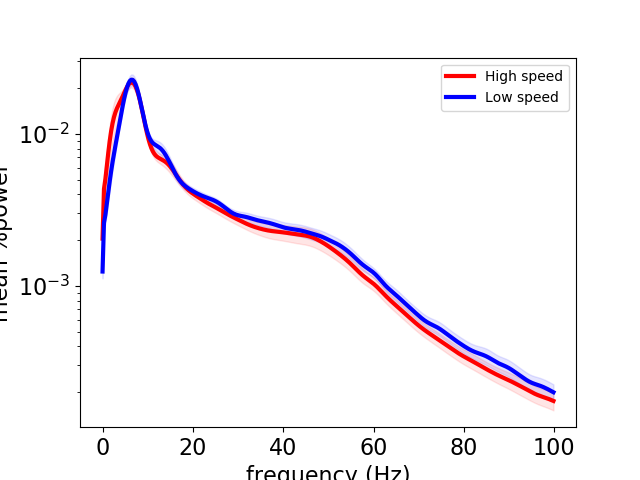

In [28]:
fig, ax = plt.subplots(1,1)
StdPrehigh = np.nanstd(phighpre, axis = 0)/np.sqrt(numS)
StdPrelow = np.nanstd(plowPre, axis = 0)/np.sqrt(numS)
ax.semilogy(f[0:cutoff], MhighPre, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], MlowPre, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], MhighPre-StdPrehigh, MhighPre+StdPrehigh,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], MlowPre-StdPrelow, MlowPre+StdPrelow,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

<IPython.core.display.Javascript object>


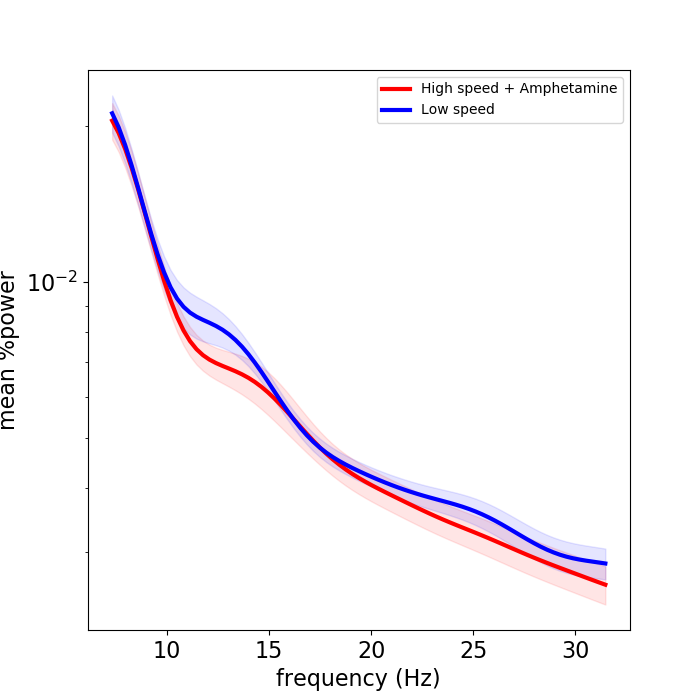

In [29]:
fig, ax = plt.subplots(1,1,figsize=(7, 7),gridspec_kw = {'top':0.9,'bottom':0.1,'wspace':0.1}
                      )
cutoff=100
ax.semilogy(f[23:cutoff], MhighPre[23:cutoff], linewidth=3,color='red', label='High speed + Amphetamine')
ax.semilogy(f[23:cutoff], MlowPre[23:cutoff], linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[23:cutoff], MhighPre[23:cutoff]-StdPrehigh[23:cutoff], MhighPre[23:cutoff]+StdPrehigh[23:cutoff],color='red',alpha=0.1)
ax.fill_between(f[23:cutoff], MlowPre[23:cutoff]-Stdlow[23:cutoff], MlowPre[23:cutoff]+Stdlow[23:cutoff],color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()


<b> calculate % time in high vs. low period + number of transitions <b>

In [25]:
dataPost_p = getData(dataFile,['lfp','mvmt'],period ='Pre',drug=b'Amphetamin' ,day = lambda x: int(x)>3)
dataPre_p = getData(dataFile,['lfp','mvmt'],period ='Pre',drug=b'Amphetamin' ,day = lambda x: int(x)==0)

cleaning up lfp data
I deleted session: 7584_day30A
I deleted session: 7909_day15A
I deleted session: 7909_day30A
cleaning up mvmt data
cleaning up lfp data
I deleted session: 4539_BaselineA
cleaning up mvmt data


<IPython.core.display.Javascript object>


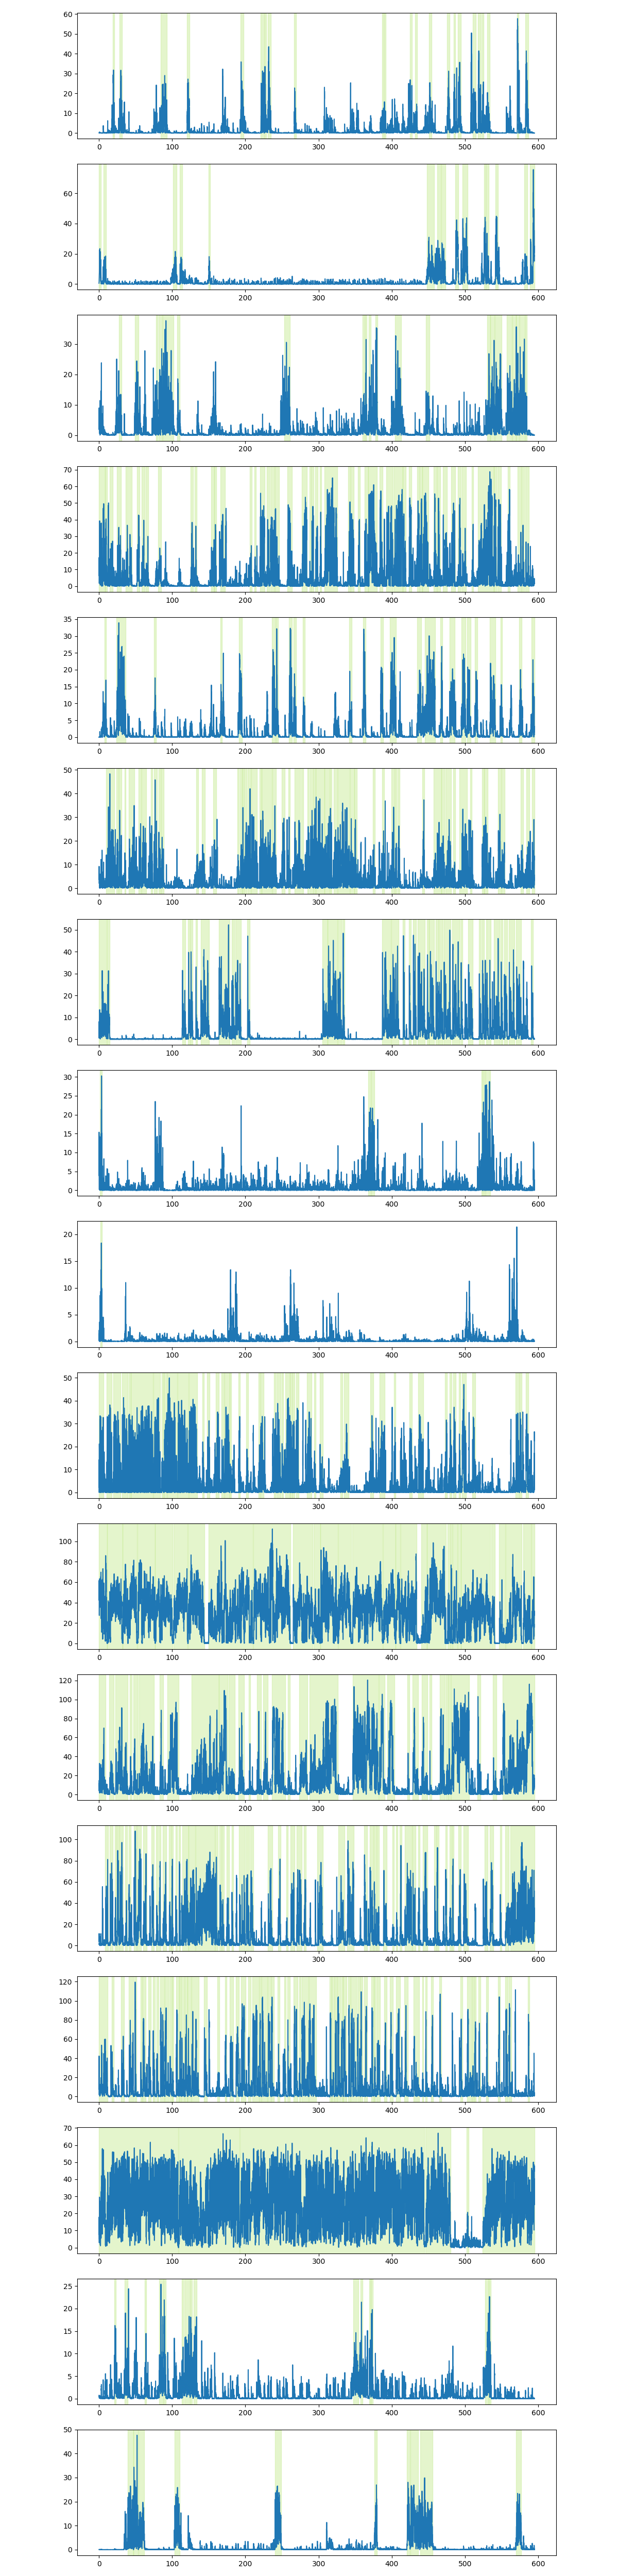

In [30]:
fig, ax = plt.subplots(len(dataPre_p.keys()),1,figsize=(12, 50),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})
Colors = CP('highLowSpeed')
dt = 1/20   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 2
dataPoints = int(np.ceil(Tseconds/dt))
th = 3
sessNum = 0
for s in dataPre_p.keys():
    #find movment onset:
    speed = dataPre_p[s]['mvmt']['speed']
    dt  = 1/dataPre_p[s]['mvmt']['Fs'][0]
    
    dataPre_p[s]['highSpeed'] = HighSpeedPeriods(ax[sessNum],speed.T,dt,th, dataPoints, Colors['high'])
    sessNum = sessNum +1

<IPython.core.display.Javascript object>


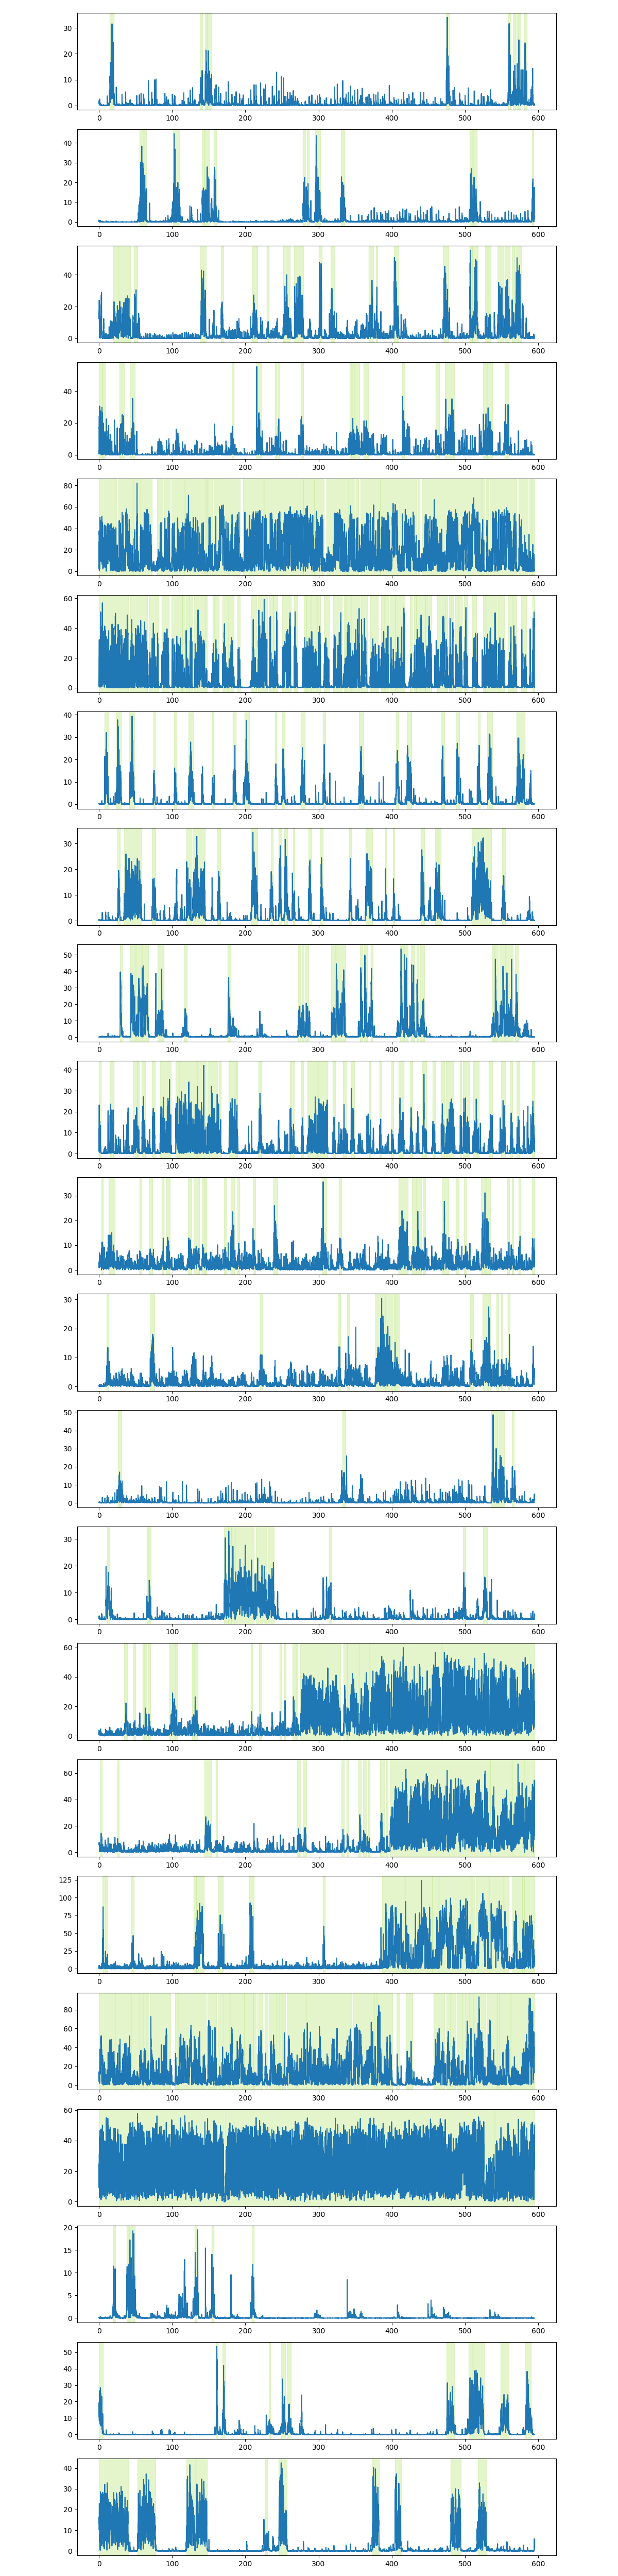

In [31]:
fig, ax = plt.subplots(len(dataPost_p.keys()),1,figsize=(12, 50),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})
Colors = CP('highLowSpeed')
dt = 1/20   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 2
dataPoints = int(np.ceil(Tseconds/dt))
th = 3
sessNum = 0
for s in dataPost_p.keys():
    #find movment onset:
    speed = dataPost_p[s]['mvmt']['speed']
    dt  = 1/dataPost_p[s]['mvmt']['Fs'][0]
    
    dataPost_p[s]['highSpeed'] = HighSpeedPeriods(ax[sessNum],speed.T,dt,th, dataPoints, Colors['high'])
    sessNum = sessNum +1

In [32]:
# create vectors from the high/low mvmt segments:
cond = ['dataPre', 'dataPost','dataPre_p', 'dataPost_p']
highVecs = {}
for c in cond:
    data = eval(c)
    highVecs[c] = {};
    for s in data.keys():
        vec = np.zeros_like(data[s]['mvmt']['speed'])
        for l in range(0, len(data[s]['highSpeed']['highSpeed']['start'])):
    
            vec[:,data[s]['highSpeed']['highSpeed']['start'][l]:data[s]['highSpeed']['highSpeed']['end'][l]]  = 1
        highVecs[c][s] = vec

In [33]:
# calculate statistics:
statsMvmt = {}

for c in highVecs.keys():
    statsMvmt[c] = {}
    hvec_mean = []
    hvec_tran = []
    
    for s in highVecs[c].keys():
        hvec_mean.append(np.mean(highVecs[c][s]))
        diff = highVecs[c][s][:,:-1]-highVecs[c][s][:,1:]
        if c in ['dataPre','dataPost']:
            hvec_tran.append(np.sum(diff == 1)/3)
        else:
            hvec_tran.append(np.sum(diff == 1))
    
    statsMvmt[c]['mean'] = hvec_mean
    statsMvmt[c]['tran'] = hvec_tran


<IPython.core.display.Javascript object>


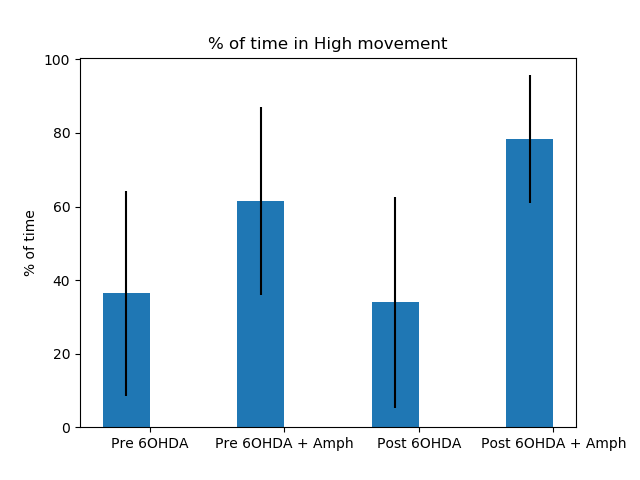

/home/dana_z/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


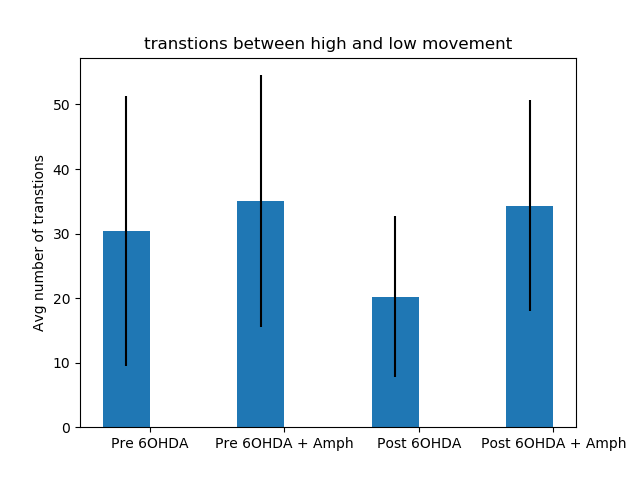

[Text(0,0,'Pre 6OHDA'),
 Text(0,0,'Pre 6OHDA + Amph'),
 Text(0,0,'Post 6OHDA'),
 Text(0,0,'Post 6OHDA + Amph')]

In [34]:
# make the bar plots:
conds = ['dataPre_p','dataPre', 'dataPost_p', 'dataPost']
labs = ['Pre 6OHDA','Pre 6OHDA + Amph', 'Post 6OHDA', 'Post 6OHDA + Amph']
means_M,means_T, std_M,std_T = [],[],[],[]
for c in conds:
    means_M.append(np.mean(statsMvmt[c]['mean'])*100)
    std_M.append(np.std(statsMvmt[c]['mean'])*100)
    means_T.append(np.mean(statsMvmt[c]['tran']))
    std_T.append(np.std(statsMvmt[c]['tran']))
ind = np.arange(len(means_M))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, means_M, width, yerr=std_M)
ax.set_ylabel('% of time')
ax.set_title('% of time in High movement')
ax.set_xticks(ind)
ax.set_xticklabels(('Pre 6OHDA','Pre 6OHDA + Amph', 'Post 6OHDA', 'Post 6OHDA + Amph'))
fig2, ax2 = plt.subplots()
rects2 = ax2.bar(ind - width/2, means_T, width, yerr=std_T)
ax2.set_title('transtions between high and low movement')
ax2.set_ylabel('Avg number of transtions')
ax2.set_xticks(ind)
ax2.set_xticklabels(('Pre 6OHDA','Pre 6OHDA + Amph', 'Post 6OHDA', 'Post 6OHDA + Amph'))

/home/dana_z/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


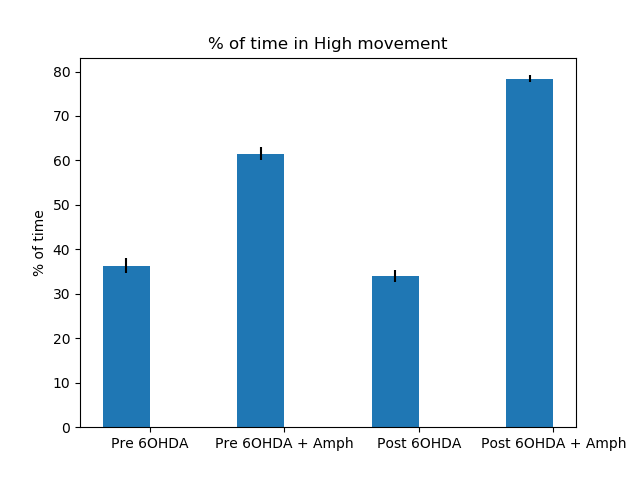

<IPython.core.display.Javascript object>


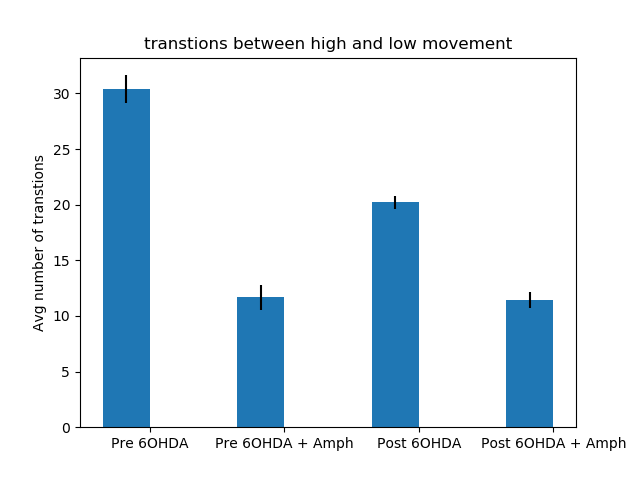

[Text(0,0,'Pre 6OHDA'),
 Text(0,0,'Pre 6OHDA + Amph'),
 Text(0,0,'Post 6OHDA'),
 Text(0,0,'Post 6OHDA + Amph')]

In [35]:
# make the bar plots:
conds = ['dataPre_p','dataPre', 'dataPost_p', 'dataPost']
labs = ['Pre 6OHDA','Pre 6OHDA + Amph', 'Post 6OHDA', 'Post 6OHDA + Amph']
means_M,means_T, std_M,std_T = [],[],[],[]
for c in conds:
    means_M.append(np.mean(statsMvmt[c]['mean'])*100)
    std_M.append(np.std(statsMvmt[c]['mean'])*100/len(statsMvmt[c]['mean']))
    if c in ['dataPre', 'dataPost']:
        means_T.append(np.mean(statsMvmt[c]['tran'])/3)
    else: 
        means_T.append(np.mean(statsMvmt[c]['tran']))
    std_T.append(np.std(statsMvmt[c]['tran'])/len(statsMvmt[c]['mean']))
ind = np.arange(len(means_M))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, means_M, width, yerr=std_M)
ax.set_ylabel('% of time')
ax.set_title('% of time in High movement')
ax.set_xticks(ind)
ax.set_xticklabels(('Pre 6OHDA','Pre 6OHDA + Amph', 'Post 6OHDA', 'Post 6OHDA + Amph'))
fig2, ax2 = plt.subplots()
rects2 = ax2.bar(ind - width/2, means_T, width, yerr=std_T)
ax2.set_title('transtions between high and low movement')
ax2.set_ylabel('Avg number of transtions')
ax2.set_xticks(ind)
ax2.set_xticklabels(('Pre 6OHDA','Pre 6OHDA + Amph', 'Post 6OHDA', 'Post 6OHDA + Amph'))

/home/dana_z/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


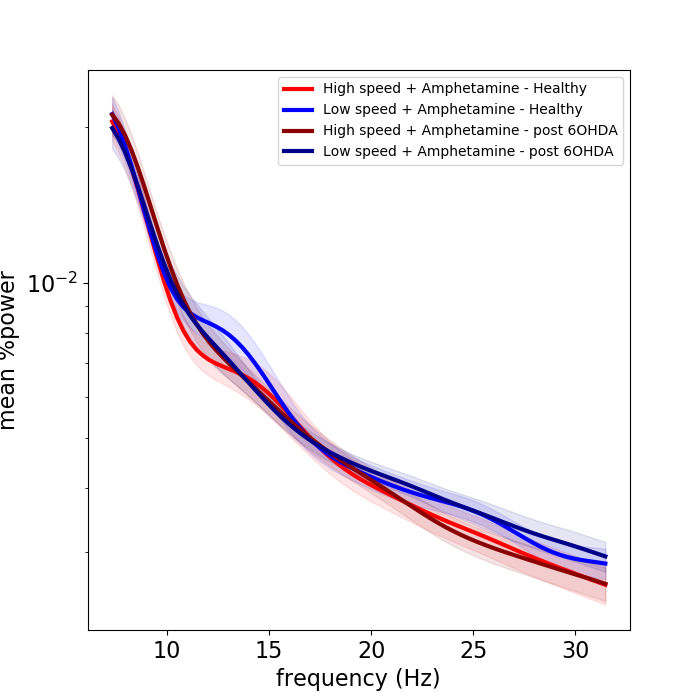

In [36]:
fig, ax = plt.subplots(1,1,figsize=(7, 7),gridspec_kw = {'top':0.9,'bottom':0.1,'wspace':0.1})
cutoff=100
ax.semilogy(f[23:cutoff], MhighPre[23:cutoff], linewidth=3,color='red', label='High speed + Amphetamine - Healthy')
ax.semilogy(f[23:cutoff], MlowPre[23:cutoff], linewidth=3,color='blue', label='Low speed + Amphetamine - Healthy')
ax.fill_between(f[23:cutoff], MhighPre[23:cutoff]-StdPrehigh[23:cutoff], MhighPre[23:cutoff]+StdPrehigh[23:cutoff],color='red',alpha=0.1)
ax.fill_between(f[23:cutoff], MlowPre[23:cutoff]-StdPrelow[23:cutoff], MlowPre[23:cutoff]+StdPrelow[23:cutoff],color='blue',alpha=0.1)

ax.semilogy(f[23:cutoff], Mhigh[23:cutoff], linewidth=3,color='darkred', label='High speed + Amphetamine - post 6OHDA')
ax.semilogy(f[23:cutoff], Mlow[23:cutoff], linewidth=3,color='darkblue', label='Low speed + Amphetamine - post 6OHDA')
ax.fill_between(f[23:cutoff], Mhigh[23:cutoff]-Stdhigh[23:cutoff], Mhigh[23:cutoff]+Stdhigh[23:cutoff],color='darkred',alpha=0.1)
ax.fill_between(f[23:cutoff], Mlow[23:cutoff]-Stdlow[23:cutoff], Mlow[23:cutoff]+Stdlow[23:cutoff],color='darkblue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()


/home/dana_z/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


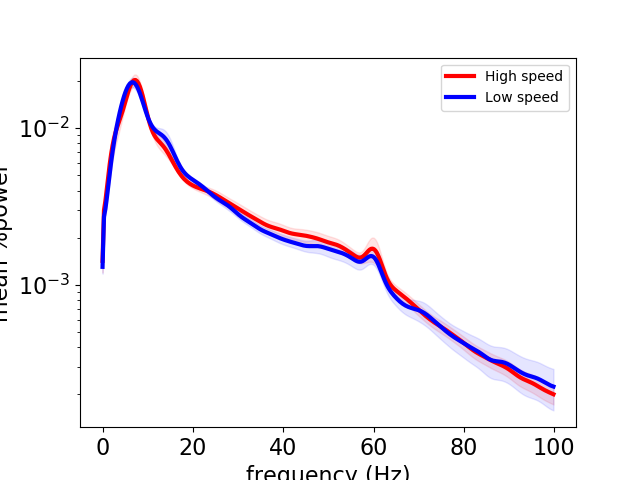

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [37]:
fig, ax = plt.subplots(1,1)
numS = len(dataPost_p.keys())
cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/dataPost_p['0761_day14A']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/dataPost_p['0761_day14A']['lfp']['FS'][0]

sNum = 0
phigh_p_post = []
plow_p_post = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in dataPost_p.keys():
    #find movment onset:
    speed = dataPost_p[s]['mvmt']['speed'].T
    lfp = dataPost_p[s]['lfp']['lfp'].T[0,:]
    if len(speed)<600:
        numS = numS-1
        continue
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winpost = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(dataPost_p[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[dataPost_p[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[dataPost_p[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh_p_post.append(Power/totPower)    
    phigh_p_post.append(PowerHigh/totPowerHigh)
    plow_p_post.append(PowerLow/totPoweLow)
phigh_p_post = np.array(phigh_p_post)
plow_p_post = np.array(plow_p_post)
Mhigh_p_post = np.nanmean(phigh_p_post,axis=0)
Mlow_p_post = np.nanmean(plow_p_post,axis=0)
Stdhigh_p_post = np.nanstd(phigh_p_post, axis = 0)/np.sqrt(numS)
Stdlow_p_post = np.nanstd(plow_p_post, axis = 0)/np.sqrt(numS)
ax.semilogy(f[0:cutoff], Mhigh_p_post, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], Mlow_p_post, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], Mhigh_p_post-Stdhigh_p_post, Mhigh_p_post+Stdhigh_p_post,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], Mlow_p_post-Stdlow_p_post, Mlow_p_post+Stdlow_p_post,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

/home/dana_z/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


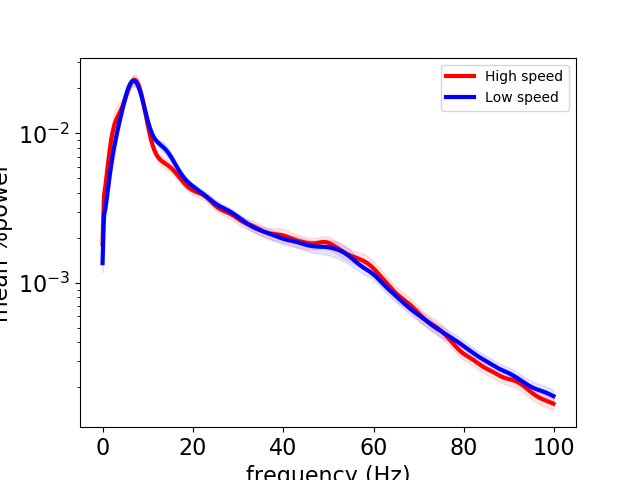

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [38]:
fig, ax = plt.subplots(1,1)
numS = len(dataPre_p.keys())
cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/dataPre_p['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/dataPre_p['1208_BaselineA']['lfp']['FS'][0]

sNum = 0
phigh_p_pre = []
plow_p_pre = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in dataPre_p.keys():
    #find movment onset:
    speed = dataPre_p[s]['mvmt']['speed'].T
    lfp = dataPre_p[s]['lfp']['lfp'].T[0,:]
    if len(speed)<600:
        numS = numS-1
        continue
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPre =40, winpre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(dataPre_p[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[dataPre_p[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[dataPre_p[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh_p_pre.append(Power/totPower)    
    phigh_p_pre.append(PowerHigh/totPowerHigh)
    plow_p_pre.append(PowerLow/totPoweLow)
phigh_p_pre = np.array(phigh_p_pre)
plow_p_pre = np.array(plow_p_pre)
Mhigh_p_pre = np.nanmean(phigh_p_pre,axis=0)
Mlow_p_pre = np.nanmean(plow_p_pre,axis=0)
Stdhigh_p_pre = np.nanstd(phigh_p_pre, axis = 0)/np.sqrt(numS)
Stdlow_p_pre = np.nanstd(plow_p_pre, axis = 0)/np.sqrt(numS)
ax.semilogy(f[0:cutoff], Mhigh_p_pre, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], Mlow_p_pre, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], Mhigh_p_pre-Stdhigh_p_pre, Mhigh_p_pre+Stdhigh_p_pre,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], Mlow_p_pre-Stdlow_p_pre, Mlow_p_pre+Stdlow_p_pre,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

In [39]:
dataPost_p2 = getData(dataFile,['lfp','mvmt'],period ='Pre' ,day = lambda x: int(x)>3)
dataPre_p2 = getData(dataFile,['lfp','mvmt'],period ='Pre' ,day = lambda x: int(x)==0)

cleaning up lfp data
I deleted session: 7584_day12
I deleted session: 7584_day30A
I deleted session: 7909_day15A
I deleted session: 7909_day30A
cleaning up mvmt data
cleaning up lfp data
I deleted session: 4539_BaselineA
cleaning up mvmt data


/home/dana_z/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


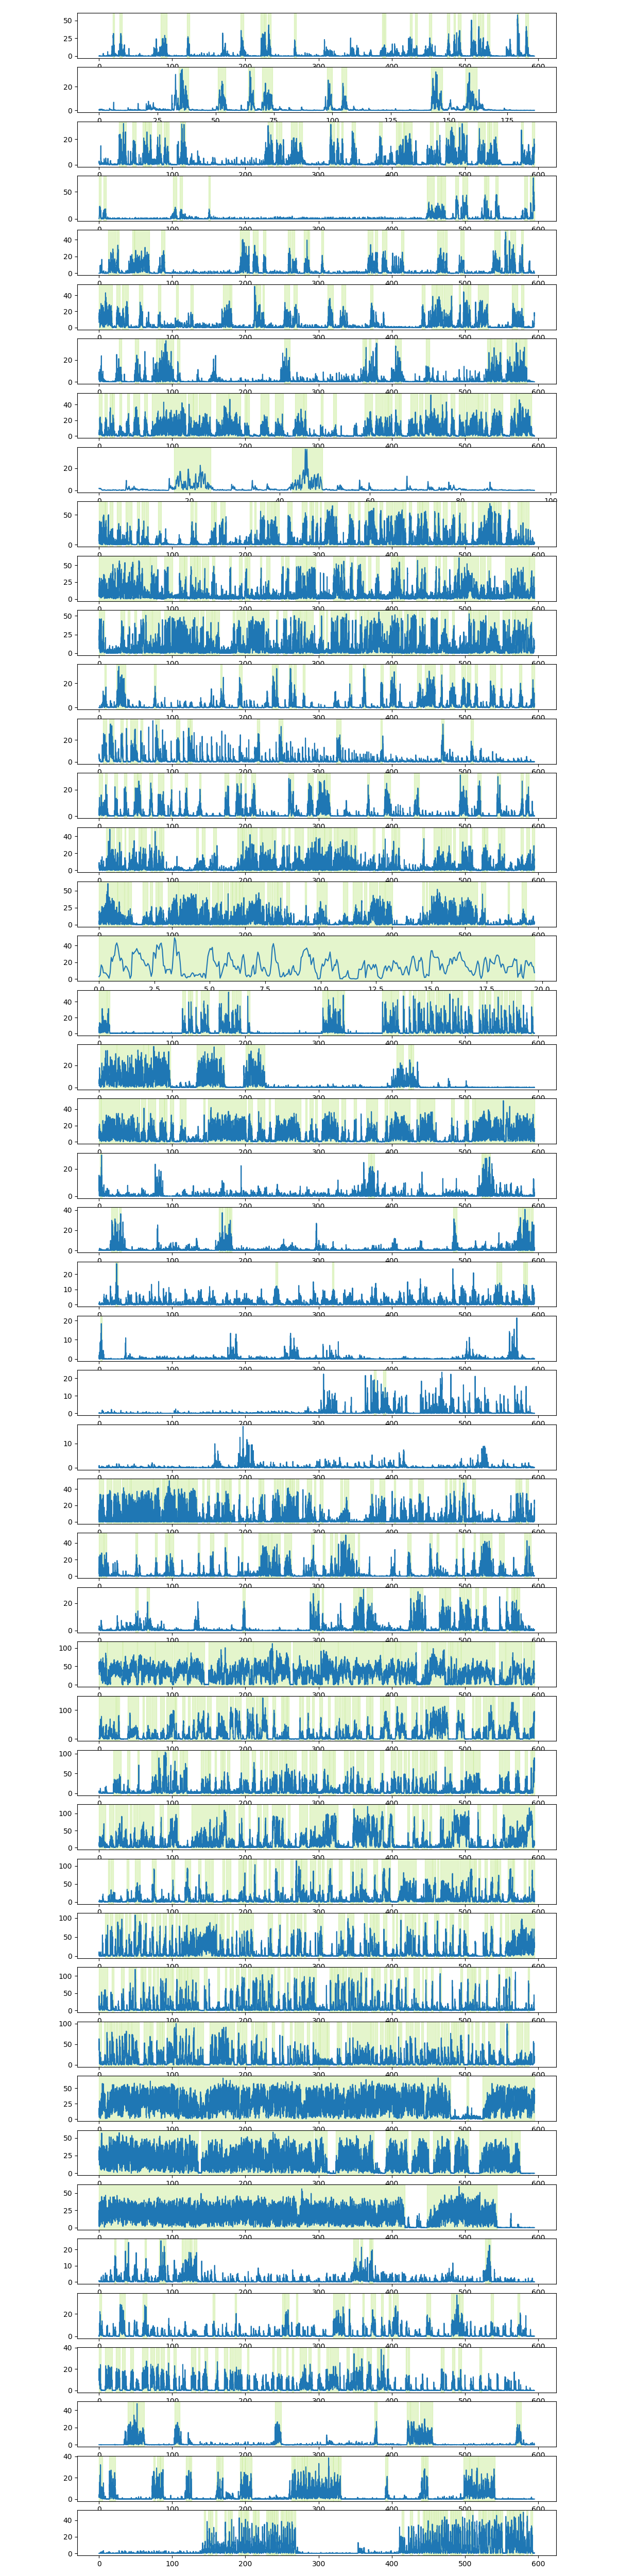

<IPython.core.display.Javascript object>


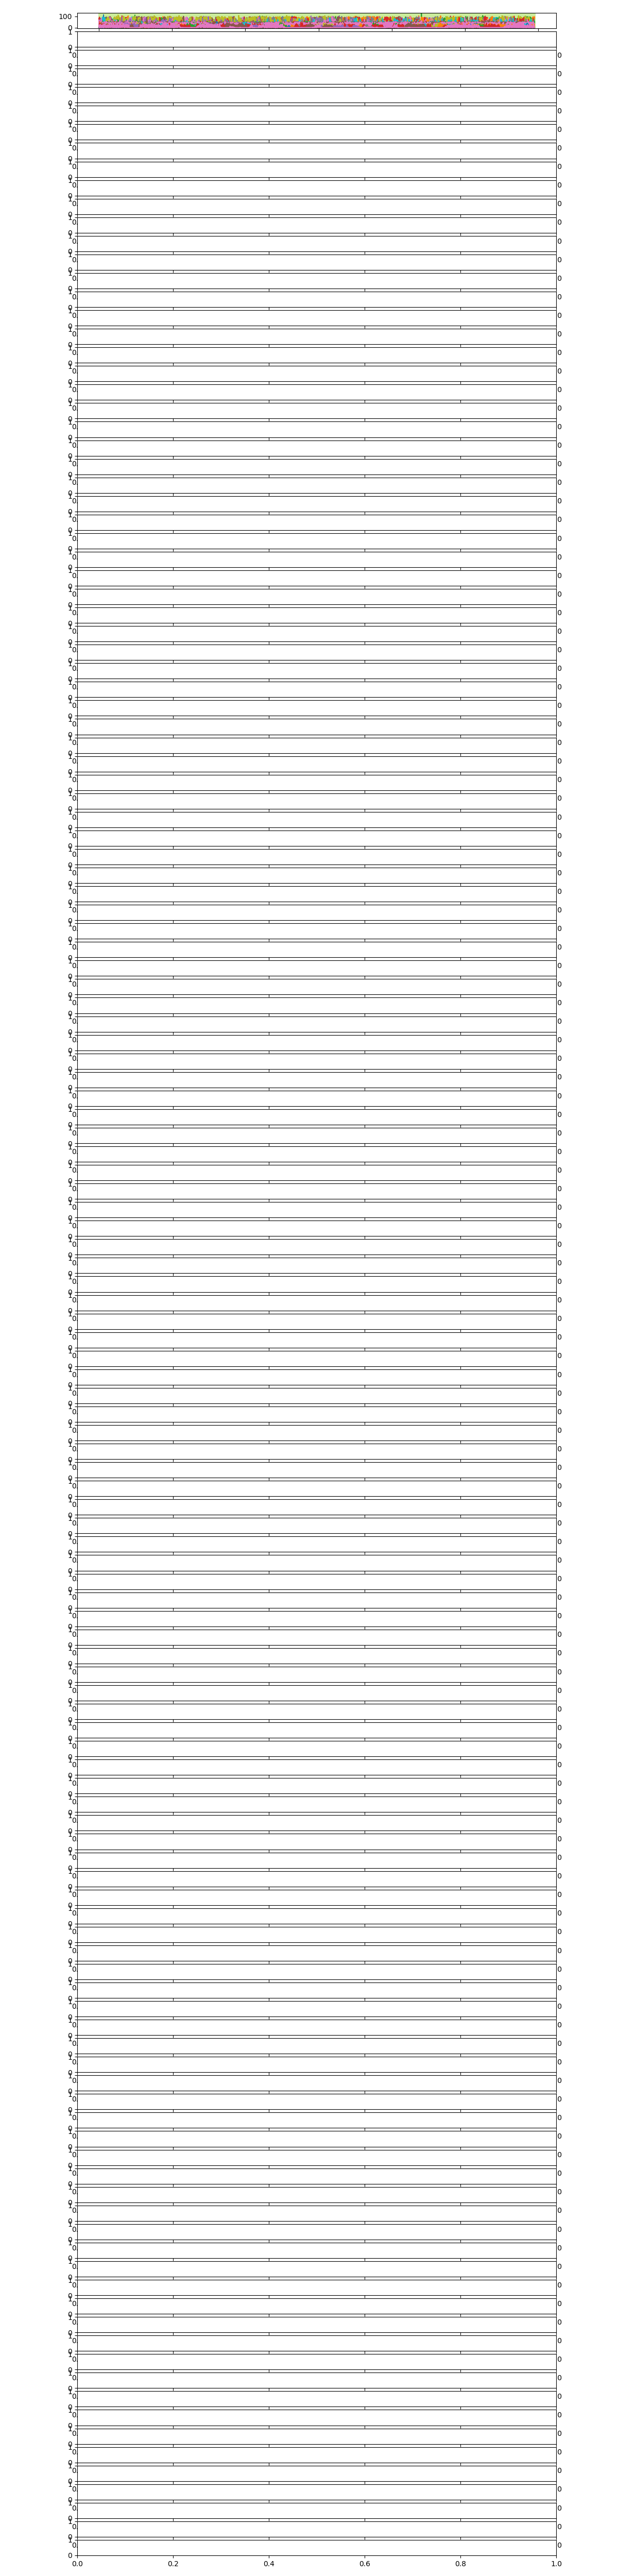

In [40]:
fig, ax = plt.subplots(len(dataPre_p2.keys()),1,figsize=(12, 50),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})
Colors = CP('highLowSpeed')
dt = 1/20   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 2
dataPoints = int(np.ceil(Tseconds/dt))
th = 3
sessNum = 0
for s in dataPre_p2.keys():
    #find movment onset:
    speed = dataPre_p2[s]['mvmt']['speed']
    dt  = 1/dataPre_p2[s]['mvmt']['Fs'][0]
    
    dataPre_p2[s]['highSpeed'] = HighSpeedPeriods(ax[sessNum],speed.T,dt,th, dataPoints, Colors['high'])
    sessNum = sessNum +1

fig, ax = plt.subplots(len(dataPost_p2.keys()),1,figsize=(12, 50),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})
Colors = CP('highLowSpeed')
dt = 1/20   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 2
dataPoints = int(np.ceil(Tseconds/dt))
th = 3
sessNum = 0
for s in dataPost_p2.keys():
    #find movment onset:
    speed = dataPost_p2[s]['mvmt']['speed']
    dt  = 1/dataPost_p2[s]['mvmt']['Fs'][0]
    
    dataPost_p2[s]['highSpeed'] = HighSpeedPeriods(ax[sessNum],speed.T,dt,th, dataPoints, Colors['high'])

/home/dana_z/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


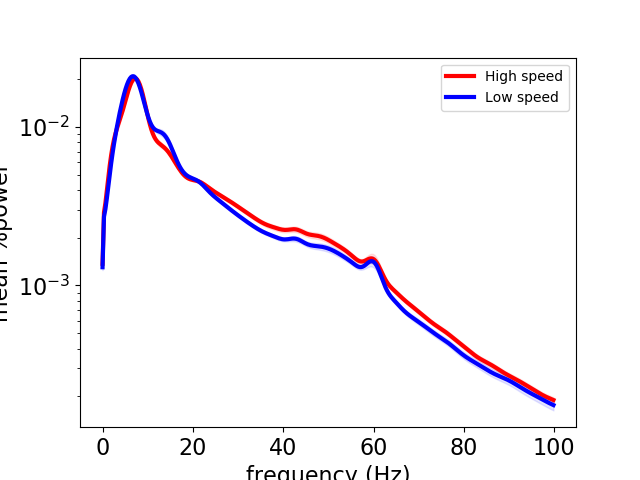

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


In [41]:
fig, ax = plt.subplots(1,1)
numS = len(dataPost_p2.keys())
cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/dataPost_p2['0761_day14A']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/dataPost_p2['0761_day14A']['lfp']['FS'][0]

sNum = 0
phigh_p2_post = []
plow_p2_post = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in dataPost_p2.keys():
    #find movment onset:
    speed = dataPost_p2[s]['mvmt']['speed'].T
    lfp = dataPost_p2[s]['lfp']['lfp'].T[0,:]
    if len(speed)<600:
        numS = numS-1
        continue
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winpost = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(dataPost_p2[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[dataPost_p2[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[dataPost_p2[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh_p2_post.append(Power/totPower)    
    phigh_p2_post.append(PowerHigh/totPowerHigh)
    plow_p2_post.append(PowerLow/totPoweLow)
phigh_p2_post = np.array(phigh_p2_post)
plow_p2_post = np.array(plow_p2_post)
Mhigh_p2_post = np.nanmean(phigh_p2_post,axis=0)
Mlow_p2_post = np.nanmean(plow_p2_post,axis=0)
Stdhigh_p2_post = np.nanstd(phigh_p2_post, axis = 0)/np.sqrt(numS)
Stdlow_p2_post = np.nanstd(plow_p2_post, axis = 0)/np.sqrt(numS)
ax.semilogy(f[0:cutoff], Mhigh_p2_post, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], Mlow_p2_post, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], Mhigh_p2_post-Stdhigh_p2_post, Mhigh_p2_post+Stdhigh_p2_post,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], Mlow_p2_post-Stdlow_p2_post, Mlow_p2_post+Stdlow_p2_post,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

/home/dana_z/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


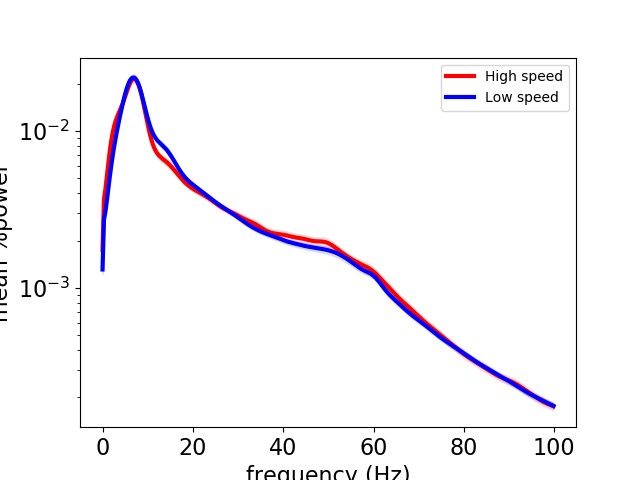

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


In [42]:
fig, ax = plt.subplots(1,1)
numS = len(dataPre_p2.keys())
cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/dataPre_p2['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/dataPre_p2['1208_BaselineA']['lfp']['FS'][0]

sNum = 0
phigh_p2_pre = []
plow_p2_pre = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in dataPre_p2.keys():
    #find movment onset:
    speed = dataPre_p2[s]['mvmt']['speed'].T
    lfp = dataPre_p2[s]['lfp']['lfp'].T[0,:]
    if len(speed)<600:
        numS = numS-1
        continue
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPre =40, winpre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(dataPre_p2[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[dataPre_p2[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[dataPre_p2[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh_p2_pre.append(Power/totPower)    
    phigh_p2_pre.append(PowerHigh/totPowerHigh)
    plow_p2_pre.append(PowerLow/totPoweLow)
phigh_p2_pre = np.array(phigh_p2_pre)
plow_p2_pre = np.array(plow_p2_pre)
Mhigh_p2_pre = np.nanmean(phigh_p2_pre,axis=0)
Mlow_p2_pre = np.nanmean(plow_p2_pre,axis=0)
Stdhigh_p2_pre = np.nanstd(phigh_p2_pre, axis = 0)/np.sqrt(numS)
Stdlow_p2_pre = np.nanstd(plow_p2_pre, axis = 0)/np.sqrt(numS)
ax.semilogy(f[0:cutoff], Mhigh_p2_pre, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], Mlow_p2_pre, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], Mhigh_p2_pre-Stdhigh_p2_pre, Mhigh_p2_pre+Stdhigh_p2_pre,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], Mlow_p2_pre-Stdlow_p2_pre, Mlow_p2_pre+Stdlow_p2_pre,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

/home/dana_z/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


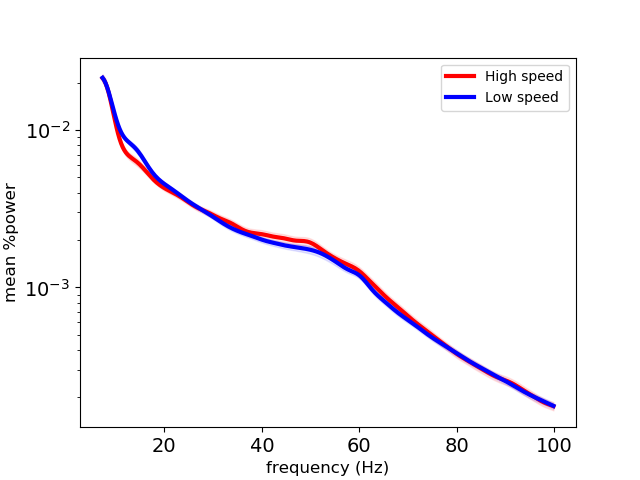

In [43]:
fig, ax = plt.subplots(1,1)
cutoff = 315
phigh_p2_pre = np.array(phigh_p2_pre)
plow_p2_pre = np.array(plow_p2_pre)
Mhigh_p2_pre = np.nanmean(phigh_p2_pre,axis=0)
Mlow_p2_pre = np.nanmean(plow_p2_pre,axis=0)
Stdhigh_p2_pre = np.nanstd(phigh_p2_pre, axis = 0)/np.sqrt(numS)
Stdlow_p2_pre = np.nanstd(plow_p2_pre, axis = 0)/np.sqrt(numS)
ax.semilogy(f[23:cutoff], Mhigh_p2_pre[23:cutoff], linewidth=3,color='red', label='High speed')
ax.semilogy(f[23:cutoff], Mlow_p2_pre[23:cutoff], linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[23:cutoff], Mhigh_p2_pre[23:cutoff]-Stdhigh_p2_pre[23:cutoff], Mhigh_p2_pre[23:cutoff]+Stdhigh_p2_pre[23:cutoff],color='red',alpha=0.1)
ax.fill_between(f[23:cutoff], Mlow_p2_pre[23:cutoff]-Stdlow_p2_pre[23:cutoff], Mlow_p2_pre[23:cutoff]+Stdlow_p2_pre[23:cutoff],color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=12)
ax.set_xlabel('frequency (Hz)',fontsize=12)
ax.tick_params(labelsize=14)
ax.legend()

/home/dana_z/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


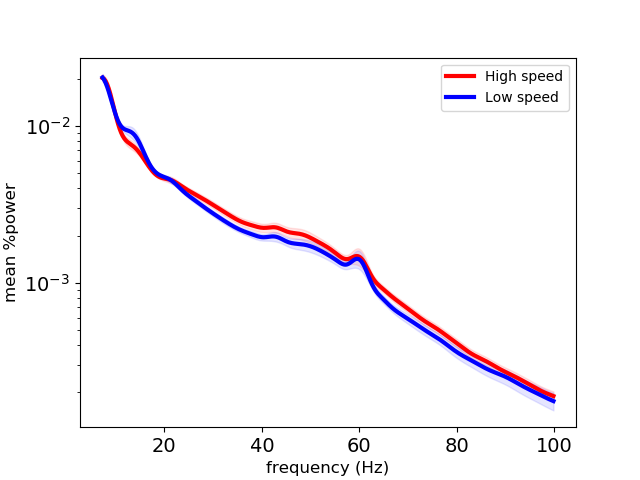

In [44]:
fig, ax = plt.subplots(1,1)
cutoff = 315
phigh_p2_post = np.array(phigh_p2_post)
plow_p2_post = np.array(plow_p2_post)
Mhigh_p2_post = np.nanmean(phigh_p2_post,axis=0)
Mlow_p2_post = np.nanmean(plow_p2_post,axis=0)
Stdhigh_p2_post = np.nanstd(phigh_p2_post, axis = 0)/np.sqrt(numS)
Stdlow_p2_post = np.nanstd(plow_p2_post, axis = 0)/np.sqrt(numS)
ax.semilogy(f[23:cutoff], Mhigh_p2_post[23:cutoff], linewidth=3,color='red', label='High speed')
ax.semilogy(f[23:cutoff], Mlow_p2_post[23:cutoff], linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[23:cutoff], Mhigh_p2_post[23:cutoff]-Stdhigh_p2_post[23:cutoff], Mhigh_p2_post[23:cutoff]+Stdhigh_p2_post[23:cutoff],color='red',alpha=0.1)
ax.fill_between(f[23:cutoff], Mlow_p2_post[23:cutoff]-Stdlow_p2_post[23:cutoff], Mlow_p2_post[23:cutoff]+Stdlow_p2_post[23:cutoff],color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=12)
ax.set_xlabel('frequency (Hz)',fontsize=12)
ax.tick_params(labelsize=14)
ax.legend()

/home/dana_z/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


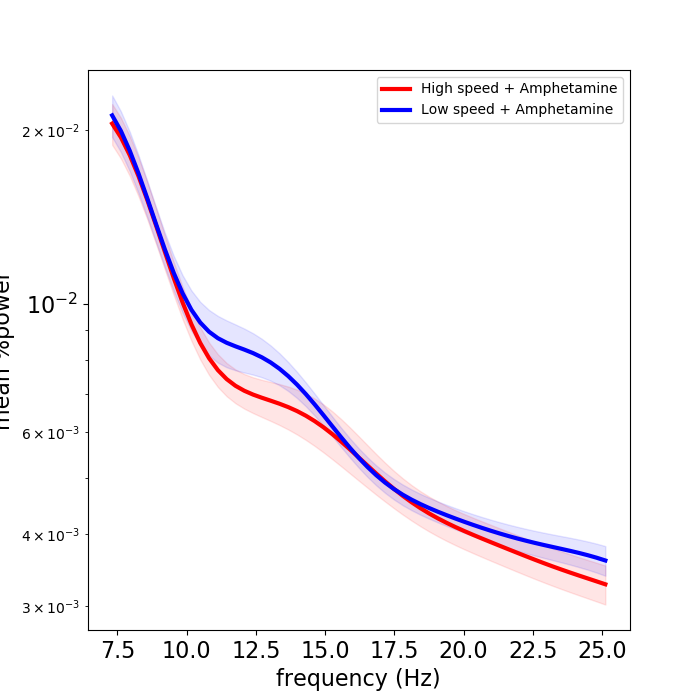

In [45]:
fig, ax = plt.subplots(1,1,figsize=(7, 7),gridspec_kw = {'top':0.9,'bottom':0.1,'wspace':0.1}
                      )
cutoff=80
cutoff1=23
ax.semilogy(f[cutoff1:cutoff], MhighPre[cutoff1:cutoff], linewidth=3,color='red', label='High speed + Amphetamine')
ax.semilogy(f[cutoff1:cutoff], MlowPre[cutoff1:cutoff], linewidth=3,color='blue', label='Low speed + Amphetamine')
ax.fill_between(f[cutoff1:cutoff], MhighPre[cutoff1:cutoff]-StdPrehigh[cutoff1:cutoff], MhighPre[cutoff1:cutoff]+StdPrehigh[cutoff1:cutoff],color='red',alpha=0.1)
ax.fill_between(f[cutoff1:cutoff], MlowPre[cutoff1:cutoff]-Stdlow[cutoff1:cutoff], MlowPre[cutoff1:cutoff]+Stdlow[cutoff1:cutoff],color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()


/home/dana_z/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


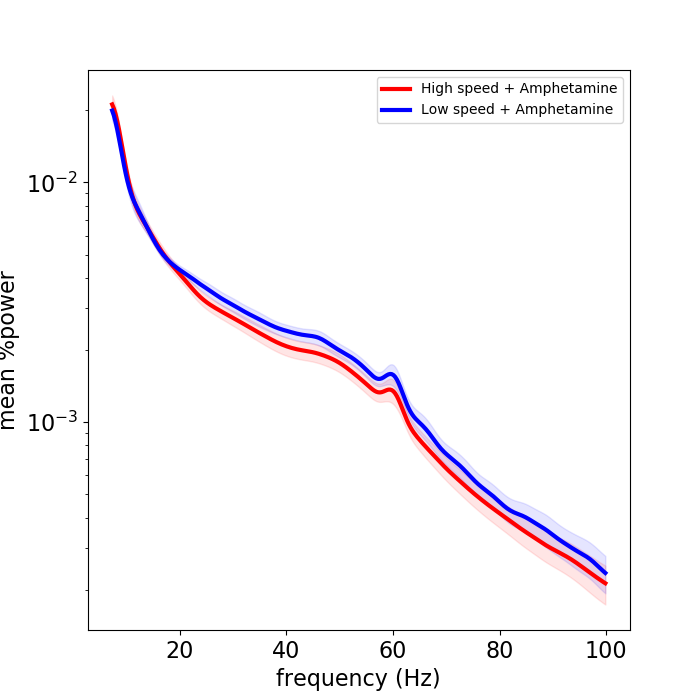

In [46]:
fig, ax = plt.subplots(1,1,figsize=(7, 7),gridspec_kw = {'top':0.9,'bottom':0.1,'wspace':0.1}
                      )
cutoff=315
cutoff1=23
ax.semilogy(f[cutoff1:cutoff], Mhigh[cutoff1:cutoff], linewidth=3,color='red', label='High speed + Amphetamine')
ax.semilogy(f[cutoff1:cutoff], Mlow[cutoff1:cutoff], linewidth=3,color='blue', label='Low speed + Amphetamine')
ax.fill_between(f[cutoff1:cutoff], Mhigh[cutoff1:cutoff]-Stdhigh[cutoff1:cutoff], Mhigh[cutoff1:cutoff]+Stdhigh[cutoff1:cutoff],color='red',alpha=0.1)
ax.fill_between(f[cutoff1:cutoff], Mlow[cutoff1:cutoff]-Stdlow[cutoff1:cutoff], Mlow[cutoff1:cutoff]+Stdlow[cutoff1:cutoff],color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()


In [47]:
Pre_tTest = sci.stats.ttest_rel(statsMvmt['dataPre']['mean'],statsMvmt['dataPre_p']['mean'])
print("Pre 6OHDA pre/post Amph",Pre_tTest)
Post_tTest = sci.stats.ttest_rel(statsMvmt['dataPost']['mean'],statsMvmt['dataPost_p']['mean'])
print("Post 6OHDA pre/post Amph",Post_tTest)
tTest_preAmph = sci.stats.ttest_ind(statsMvmt['dataPre_p']['mean'],statsMvmt['dataPost_p']['mean'])
print("Pre Amph pre/post 6OHDA",tTest_preAmph)
tTest_postAmph = sci.stats.ttest_ind(statsMvmt['dataPre']['mean'],statsMvmt['dataPost']['mean'])
print("Post Amph pre/post 6OHDA",tTest_postAmph)
print('')
print('')
Pre_tTest = sci.stats.ttest_rel(statsMvmt['dataPre']['tran'],statsMvmt['dataPre_p']['tran'])
print("Pre 6OHDA pre/post Amph",Pre_tTest)
Post_tTest = sci.stats.ttest_rel(statsMvmt['dataPost']['tran'],statsMvmt['dataPost_p']['tran'])
print("Post 6OHDA pre/post Amph",Post_tTest)
tTest_preAmph = sci.stats.ttest_ind(statsMvmt['dataPre_p']['tran'],statsMvmt['dataPost_p']['tran'])
print("Pre Amph pre/post 6OHDA",tTest_preAmph)
tTest_postAmph = sci.stats.ttest_ind(statsMvmt['dataPre']['tran'],statsMvmt['dataPost']['tran'])
print("Post Amph pre/post 6OHDA",tTest_postAmph)

Pre 6OHDA pre/post Amph Ttest_relResult(statistic=3.7812395677037576, pvalue=0.0016362384453947046)
Post 6OHDA pre/post Amph Ttest_relResult(statistic=6.697387216462723, pvalue=1.2551851987217444e-06)
Pre Amph pre/post 6OHDA Ttest_indResult(statistic=0.2533646828983239, pvalue=0.8013889617585866)
Post Amph pre/post 6OHDA Ttest_indResult(statistic=-2.3833732226388378, pvalue=0.022400637783642277)


Pre 6OHDA pre/post Amph Ttest_relResult(statistic=0.7480950879096188, pvalue=0.4652575880342251)
Post 6OHDA pre/post Amph Ttest_relResult(statistic=3.6428475685697816, pvalue=0.0015210276921288055)
Pre Amph pre/post 6OHDA Ttest_indResult(statistic=1.8373462784489218, pvalue=0.07420038414405897)
Post Amph pre/post 6OHDA Ttest_indResult(statistic=0.11299522368881104, pvalue=0.9106452057130254)


In [48]:
print(len(dataPre.keys()))
print(len(dataPost.keys()))
print(len(dataPre_p.keys()))
print(len(dataPost_p.keys()))
print(len(dataPre_p2.keys()))
print(len(dataPost_p2.keys()))

17
22
17
22
47
137


/home/dana_z/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


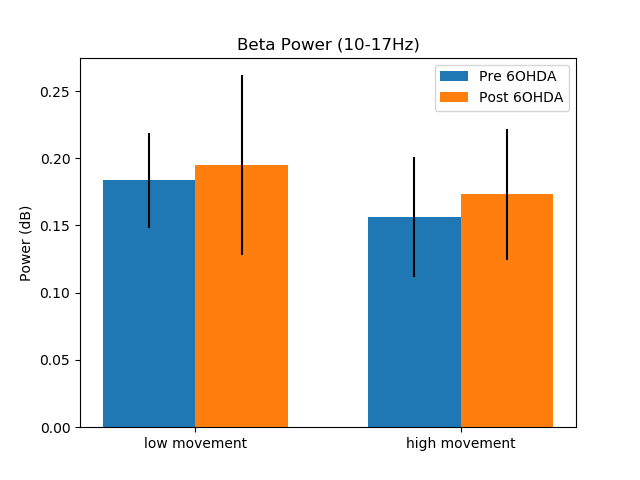

In [55]:
# 10-17Hz = f[32:55]
highPre6OHDA = np.sum(phigh_p2_pre[:,32:55],axis=1)
lowPre6OHDA = np.sum(plow_p2_pre[:,32:55],axis=1)
highPost6OHDA = np.sum(phigh_p2_post[:,32:55],axis=1)
lowPost6OHDA = np.sum(plow_p2_post[:,32:55],axis=1)

conds = ['low', 'high']
labs = ['Pre 6OHDA','Pre 6OHDA + Amph', 'Post 6OHDA', 'Post 6OHDA + Amph']
means_Pre,means_Post, std_Pre,std_Post = [],[],[],[]
for c in conds:
    PreD = eval(c+'Pre6OHDA')
    PostD = eval(c+'Post6OHDA')
    means_Pre.append(np.nanmean(PreD))
    std_Pre.append(np.nanstd(PreD))
    means_Post.append(np.nanmean(PostD))
    std_Post.append(np.nanstd(PostD))


ind = np.arange(len(means_Pre))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, means_Pre, width, yerr=std_Pre, label='Pre 6OHDA')
rects2 = ax.bar(ind + width/2, means_Post, width, yerr=std_Post, label='Post 6OHDA')

ax.set_ylabel('Power (dB)')
ax.set_title('Beta Power (10-17Hz)')
ax.set_xticks(ind)
ax.set_xticklabels(('low movement','high movement'))
ax.legend()



In [51]:
Pre_nonParam = sci.stats.mannwhitneyu(statsMvmt['dataPre']['mean'],statsMvmt['dataPre_p']['mean'])
print("Pre 6OHDA pre/post Amph",Pre_nonParam)
Post_nonParam = sci.stats.mannwhitneyu(statsMvmt['dataPost']['mean'],statsMvmt['dataPost_p']['mean'])
print("Post 6OHDA pre/post Amph",Post_nonParam)
nonParam_preAmph = sci.stats.ranksums(statsMvmt['dataPre_p']['mean'],statsMvmt['dataPost_p']['mean'])
print("Pre Amph pre/post 6OHDA",nonParam_preAmph)
nonParam_postAmph = sci.stats.ranksums(statsMvmt['dataPre']['mean'],statsMvmt['dataPost']['mean'])
print("Post Amph pre/post 6OHDA",nonParam_postAmph)
print('')
print('')
Pre_nonParam = sci.stats.mannwhitneyu(statsMvmt['dataPre']['tran'],statsMvmt['dataPre_p']['tran'])
print("Pre 6OHDA pre/post Amph",Pre_nonParam)
Post_nonParam = sci.stats.mannwhitneyu(statsMvmt['dataPost']['tran'],statsMvmt['dataPost_p']['tran'])
print("Post 6OHDA pre/post Amph",Post_nonParam)
nonParam_preAmph = sci.stats.ranksums(statsMvmt['dataPre_p']['tran'],statsMvmt['dataPost_p']['tran'])
print("Pre Amph pre/post 6OHDA",nonParam_preAmph)
nonParam_postAmph = sci.stats.ranksums(statsMvmt['dataPre']['tran'],statsMvmt['dataPost']['tran'])
print("Post Amph pre/post 6OHDA",nonParam_postAmph)
print('')
print('')
Low_nonParam = sci.stats.mannwhitneyu(lowPre6OHDA,highPre6OHDA)
print("Pre 6OHDA high/low mvmt",Low_nonParam)
High_nonParam = sci.stats.mannwhitneyu(lowPost6OHDA,highPost6OHDA)
print("Post 6OHDA high/low mvmt",High_nonParam)
nonParam_pre = sci.stats.ranksums(lowPre6OHDA,lowPost6OHDA)
print("low mvmt pre/post 6OHDA",nonParam_pre)
nonParam_post = sci.stats.ranksums(highPre6OHDA,highPost6OHDA)
print("high mvmt pre/post 6OHDA",nonParam_post)



Pre 6OHDA pre/post Amph MannwhitneyuResult(statistic=68.0, pvalue=0.004426120384213286)
Post 6OHDA pre/post Amph MannwhitneyuResult(statistic=61.0, pvalue=1.1335939133615017e-05)
Pre Amph pre/post 6OHDA RanksumsResult(statistic=0.28322059201851035, pvalue=0.7770077441735238)
Post Amph pre/post 6OHDA RanksumsResult(statistic=-2.0108662033314237, pvalue=0.0443395910098411)


Pre 6OHDA pre/post Amph MannwhitneyuResult(statistic=129.0, pvalue=0.30265786362348335)
Post 6OHDA pre/post Amph MannwhitneyuResult(statistic=128.0, pvalue=0.003854929387341392)
Pre Amph pre/post 6OHDA RanksumsResult(statistic=1.3877809008907007, pvalue=0.16520377232764716)
Post Amph pre/post 6OHDA RanksumsResult(statistic=-0.14161029600925518, pvalue=0.8873878338583713)


Pre 6OHDA high/low mvmt MannwhitneyuResult(statistic=550.0, pvalue=3.7002233739619574e-05)
Post 6OHDA high/low mvmt MannwhitneyuResult(statistic=6760.0, pvalue=6.285410869183634e-05)
low mvmt pre/post 6OHDA RanksumsResult(statistic=-0.3949813035816

In [58]:
print(np.nanmean(highPre6OHDA),np.nanmean(highPost6OHDA),np.nanmean(lowPre6OHDA),np.nanmean(lowPost6OHDA))
#print(len(statsMvmt['dataPre']['mean']),len(statsMvmt['dataPost']['mean']))

0.1565421819209531 0.17308375145682425 0.18346364960912356 0.1950417127099226


In [ ]:
# 10-17Hz = f[32:55]
from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
    setp(bp['fliers'][0], color='blue')
    setp(bp['fliers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
    setp(bp['fliers'][1], color='red')
    setp(bp['fliers'][1], color='red')
    setp(bp['medians'][1], color='red')


highPre6OHDA = np.nansum(phigh_p2_pre[:,32:55],axis=1)
lowPre6OHDA = np.nansum(plow_p2_pre[:,32:55],axis=1)
highPost6OHDA = np.nansum(phigh_p2_post[:,32:55],axis=1)
lowPost6OHDA = np.nansum(plow_p2_post[:,32:55],axis=1)

dataH = [highPre6OHDA.T, highPost6OHDA.T]
dataL = [lowPre6OHDA.T , lowPost6OHDA.T]
#ind = np.arange(len(means_Pre))
#width = 0.35
fig = figure()
ax = axes()
hold(True)
#rects1 = ax.bar(ind - width/2, means_Pre, width, yerr=std_Pre, label='Pre 6OHDA')
#rects2 = ax.bar(ind + width/2, means_Post, width, yerr=std_Post, label='Post 6OHDA')
 
bp = boxplot(dataL, positions = [1, 2], widths = 0.6)
setBoxColors(bp)

bp = boxplot(dataH, positions = [4, 5], widths = 0.6)
setBoxColors(bp)

ax.set_xticklabels(['Low Movement', 'High Movement'])
xlim(0,6)
ylim(0,.6)
ax.set_xticks([1.5, 4.5])         
         
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('Pre 6-OHDA', 'Post 6-OHDA'))
hB.set_visible(False)
hR.set_visible(False)

ax.set_ylabel('Power (dB)')
ax.set_title('Beta Power (10-17Hz)')
#ax.set_xticks(ind)
#ax.set_xticklabels(('low movement','high movement'))
#ax.legend()



<IPython.core.display.Javascript object>


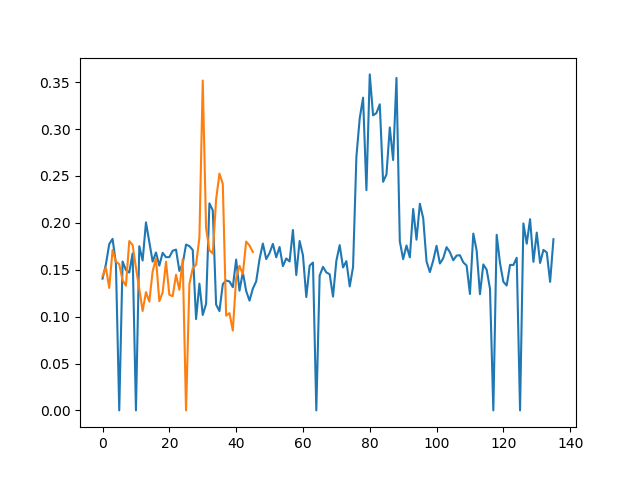

In [102]:
#print([highPre6OHDA.T, lowPre6OHDA.T, highPost6OHDA.T, lowPost6OHDA.T])

plt.plot(highPost6OHDA)
plt.plot(highPre6OHDA)
